# SelectQAOA: Regression Test Case Selection Using QAOAs
Regression testing is an important part of the software development process in software engineering. It is a practice aimed at identifying any regression, which is the emergence of new defects or issues in a software application following changes, enhancements, or updates made to the source code. In other words, regression testing focuses on how changes made to the software can affect the correct behavior of existing features. Regression testing is particularly important in agile software development environments, where changes are made frequently and rapidly. This practice helps ensure that the software remains stable and reliable as it evolves over time. Ideal regression testing would re-run all the available test cases of a given software system. However, in addition to being potentially very costly, this could even be impractical in some case. In this scenario, test case selection is one of the most widely investigated test suite optimization approaches.
Test case selection focuses on selecting a subset from an initial test suite to test software changes, i.e., to test whether unmodified parts of a program continue to work correctly after changes involving other parts. Furthermore, while in Test Case Minimization, not selecting a test case means permanently removing it; in Test Case Selection, the identified subset of the starting test suite is bounded to a specific execution of regression testing. Various techniques, such as Integer Programming, symbolic execution, data flow analysis, dependence graph-based methods, and flow graph-based approaches, can be employed to identify the modified portions of the software. Once test cases covering the unchanged program segments are pinpointed using a specific technique, an optimization algorithm (e.g., additional greedy, DIV-GA,
SelectQA, BootQA or SelectQAOA) can select a minimal set of these test cases based on certain testing criteria (e.g., branch coverage). The ultimate aim is to reduce the expenses associated with regression testing.

## Quantum Approximate Optimization Algorithm (QAOA)
The Quantum Approximate Optimization Algorithm (QAOA) is a quantum algorithm designed to tackle combinatorial optimization problems by combining classical and quantum computing techniques. It encodes the optimization problem into a Quantum Unconstrained Binary Optimization (QUBO) format and constructs a parameterized quantum circuit that alternates between applying the problem Hamiltonian, which represents the optimization goal, and a mixing Hamiltonian, which promotes exploration of the solution space. The parameters of this circuit are optimized using classical optimization methods to maximize the likelihood of measuring the optimal solution. Once the parameters are tuned, the circuit is executed on a quantum device or simulator to get candidate solutions, making QAOA particularly suitable for NP-hard problems like graph partitioning and maximum cut. This hybrid approach highlights the potential of quantum computing to provide advantages in solving complex optimization challenges.

In [1]:
import ast
import csv
import json
#this cell contains all the imports needed by the pipeline
#to run it on the browser: jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
import os
import random
import statistics
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import mannwhitneyu, shapiro
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Multi-Objective SelectQAOA
The first part of this work aims to compare SelectQAOA to the Multi-Objective DIV-GA, Additional Greedy, and SelectQA in terms of effectiveness and efficiency.
So, we will first focus on the implementation of a Multi-Objective version of SelectQAOA.

### The dataset
To experiment the performance of the proposed solution by this work and to compare its results to those of the classical state-of-the-art solutions, four public programs have been downloaded from the SIR website. SIR is a repository of software-related artifacts meant to support rigorous controlled experimentation with program analysis and software testing techniques, and education in controlled experimentation. 

### Chosen SIR Programs
The programs that will be used for experimentation have all been written in C and are:
- flex (a program that generates a lexical analysis program, based on regular expressions and C statement contained in one or more input files);
- grep (a useful program to search for matching patterns in a file);
- gzip (a program that substitutes a file, generally text files or web pages, with their compressed version)
- sed (a powerful program for stream text editing).

### Necessary information
The information needed by the quantum algorithm to work on every one of the four programs is:
- a fault matrix: it indicates whether a precise test case already found, during previous execution, a bug in the source code or not;
- execution cost: it indicates the execution cost of any test case of the suite;
- statement coverage: it indicates statement coverage information for every test case. 

All this information has been gathered through previous experimentation on the four programs mentioned above and written in files organized in the SIR_Programs folder. So, the first goal of the project will be gathering data from these files for computational purposes.

In [2]:
#this cell contains all variable definitions that will be useful throughout the entire project
# sir_programs = ["flex","grep","gzip","sed"]
# sir_programs_tests_number = {"flex":567,"grep":806,"gzip":214,"sed":360}
# sir_programs_end_lines = {"flex":14192,"grep":13281,"gzip":6701,"sed":7118}
# sir_programs_rep_values = {"flex":1,"grep":1,"gzip":1,"sed":1}
QRT_ADAS = "qrt_adas"
alpha = 0.5
experiments = 10

In [3]:
def json_keys_to_int(d):
    """This method correctly converts the data"""
    if isinstance(d, dict):
        return {int(k) if k.isdigit() else k: json_keys_to_int(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [json_keys_to_int(i) for i in d]
    else:
        return d
    
def extract_collisions(scenarios):
    """
    Estrae un flag binario (1 se c'è una collisione, 0 altrimenti) per ogni scenario.
    Controlla 'event_type' direttamente nell'oggetto scenario (che è un singolo evento).
    """
    collision_flags = []
    
    for s in scenarios:
        has_collision = 1 if s.get("event_type") == "collision" else 0
        collision_flags.append(has_collision)
        
    return collision_flags

def load_scenarios_from_folder(folder_path):
    """
    Carica tutti i file JSON da una cartella specificata, inclusi quelli nelle sottocartelle.
    Ogni file JSON è atteso essere una LISTA di eventi.
    Il codice estrarrà il PRIMO evento come rappresentativo dello scenario.
    """
    scenarios = []
    print(f"Caricamento scenari dalla cartella: {folder_path} (e sottocartelle)")
    if not os.path.exists(folder_path):
        print(f"⚠️ Attenzione: La cartella '{folder_path}' non esiste.")
        return []

    # Utilizza os.walk per attraversare l'albero delle directory
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".json"):
                file_path = os.path.join(root, filename)  # Usa 'root' per costruire il percorso completo
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)

                        if isinstance(data, list) and data:
                            if data:  # Assicurati che la lista non sia vuota
                                scenario_event_data = data[0]
                                scenario_event_data['original_filename'] = filename
                                scenarios.append(scenario_event_data)
                            else:
                                print(f"⚠️ Attenzione: Il file {filename} è una lista vuota. Saltato.")
                        else:
                            print(
                                f"❌ Errore: Il file {filename} non contiene una lista valida di eventi o ha un formato inatteso. Saltato.")

                except json.JSONDecodeError as e:
                    print(f"❌ Errore di decodifica JSON nel file {filename}: {e}")
                except Exception as e:
                    print(f"❌ Errore generico durante la lettura/elaborazione del file {filename}: {e}")
    print(f"Caricati {len(scenarios)} scenari.")
    return scenarios, len(scenarios)

def compute_div_scores(scenarios):
    """
    Calcola il punteggio di diversità (div_score) per ogni scenario.
    Gestisce campi presenti o assenti in base al tipo di evento.
    """
    records = []

    for idx, s in enumerate(scenarios):
        record = {
            "id": idx,
            "town": s.get("town", None),
            "road_type_at_collision": s.get("road_type_at_collision", None)
        }

        record.update(s.get("weather", {}))
        record.update(s.get("town_characteristics", {}))

        records.append(record)

    df = pd.DataFrame(records)

    cat_cols = ['town']
    if 'road_type_at_collision' in df.columns:
        cat_cols.append('road_type_at_collision')

    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_encoded_df = pd.DataFrame()
    if not df.empty and any(col in df.columns for col in cat_cols):
        actual_cat_cols = [col for col in cat_cols if col in df.columns]
        if actual_cat_cols:
            cat_encoded = encoder.fit_transform(df[actual_cat_cols])
            cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(actual_cat_cols))

    all_cols_except_id_cat = [col for col in df.columns if col not in ["id"] + cat_cols]

    numeric_df = df[all_cols_except_id_cat].apply(pd.to_numeric, errors='coerce')
    numeric_df = numeric_df.dropna(axis=1, how='all')
    num_cols_final = numeric_df.columns.tolist()

    scaler = MinMaxScaler()
    num_scaled_df = pd.DataFrame()
    if not numeric_df.empty:
        num_scaled = scaler.fit_transform(numeric_df.fillna(0))
        num_scaled_df = pd.DataFrame(num_scaled, columns=num_cols_final)

    X = pd.concat([num_scaled_df.reset_index(drop=True), cat_encoded_df.reset_index(drop=True)], axis=1)

    if X.empty or X.shape[0] < 2:
        print(
            "Avviso: Meno di 2 scenari o dati insufficienti per calcolare la diversità. Restituendo punteggi di diversità 0.")
        return [0.0] * len(scenarios)

    dist_matrix = pairwise_distances(X, metric='manhattan')

    div_scores = [
        float(np.mean(np.delete(dist_matrix[i], i)))
        for i in range(len(dist_matrix))
    ]

    return div_scores

scenarios, tot_test_cases = load_scenarios_from_folder("./simulation_output")
collisions = extract_collisions(scenarios)
div_scores = compute_div_scores(scenarios)

test_cases_costs = [60] * tot_test_cases

# print(collisions)
# print("=======")
# print(div_scores)
# print("=======")
# print(tot_test_cases)


Caricamento scenari dalla cartella: ./simulation_output (e sottocartelle)
Caricati 497 scenari.


## Problem Decomposition with Clustering
The qubit availability is the most significant limitation of the currently available quantum computers.
Therefore, the test suites to optimize are decomposed into smaller sub-suites solvable by QAOA simulators using clustering techniques. Applying clustering allows for preserving the similarities between test cases in sub-suites, and since similar test cases tend to have redundant coverage, the optimization process will facilitate useless duplications. Also, the similarities between test cases of the same clusters imply a diversified representation of the initial suite, facilitating targeted balancing of the goal while building a diversified final sub-suite.

## QUBO Problems
A Quadratic Unconstrained Binary Optimization (QUBO) problem is a type of mathematical problem where we seek to find the best combination of binary values (0 or 1) for a set of variables to minimize or maximize an objective function. In other words, we are looking for the optimal solution among all possible variable combinations that satisfies certain constraints and makes the objective function as small as possible.

Weights for constraints (or penalty coefficients) are used in QUBO problems to assign a numerical value to the constraints and influence the optimization process. These weights are important because they allow for managing the priority and relative importance of constraints within the optimization problem.

SelectQAOA Decomposition Time(ms): 5.515575408935547
Cluster 30 metrics:
Test Cases: [2, 4, 161, 405, 444, 483, 486]
 - Num. Test Cases: 7.00
 - Execution Cost: 420.00
 - Collisions: 0
 - Total Diversity Score: 44.696779365540266

Cluster 37 metrics:
Test Cases: [10, 293, 360, 414, 445, 492]
 - Num. Test Cases: 6.00
 - Execution Cost: 360.00
 - Collisions: 0
 - Total Diversity Score: 48.57433901575392

Cluster 38 metrics:
Test Cases: [12, 110, 136, 140, 269, 276, 312]
 - Num. Test Cases: 7.00
 - Execution Cost: 420.00
 - Collisions: 0
 - Total Diversity Score: 53.37582540133119

Cluster 16 metrics:
Test Cases: [13, 129, 229, 286, 382]
 - Num. Test Cases: 5.00
 - Execution Cost: 300.00
 - Collisions: 5
 - Total Diversity Score: 28.8822391317428

Cluster 43 metrics:
Test Cases: [16, 65, 267, 307, 426, 434]
 - Num. Test Cases: 6.00
 - Execution Cost: 360.00
 - Collisions: 6
 - Total Diversity Score: 48.10023426833184

Cluster 22 metrics:
Test Cases: [20, 28, 195, 319, 321, 358, 393]
 - Nu

C:\Users\akasa\AppData\Local\Temp\ipykernel_24836\1258138845.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters


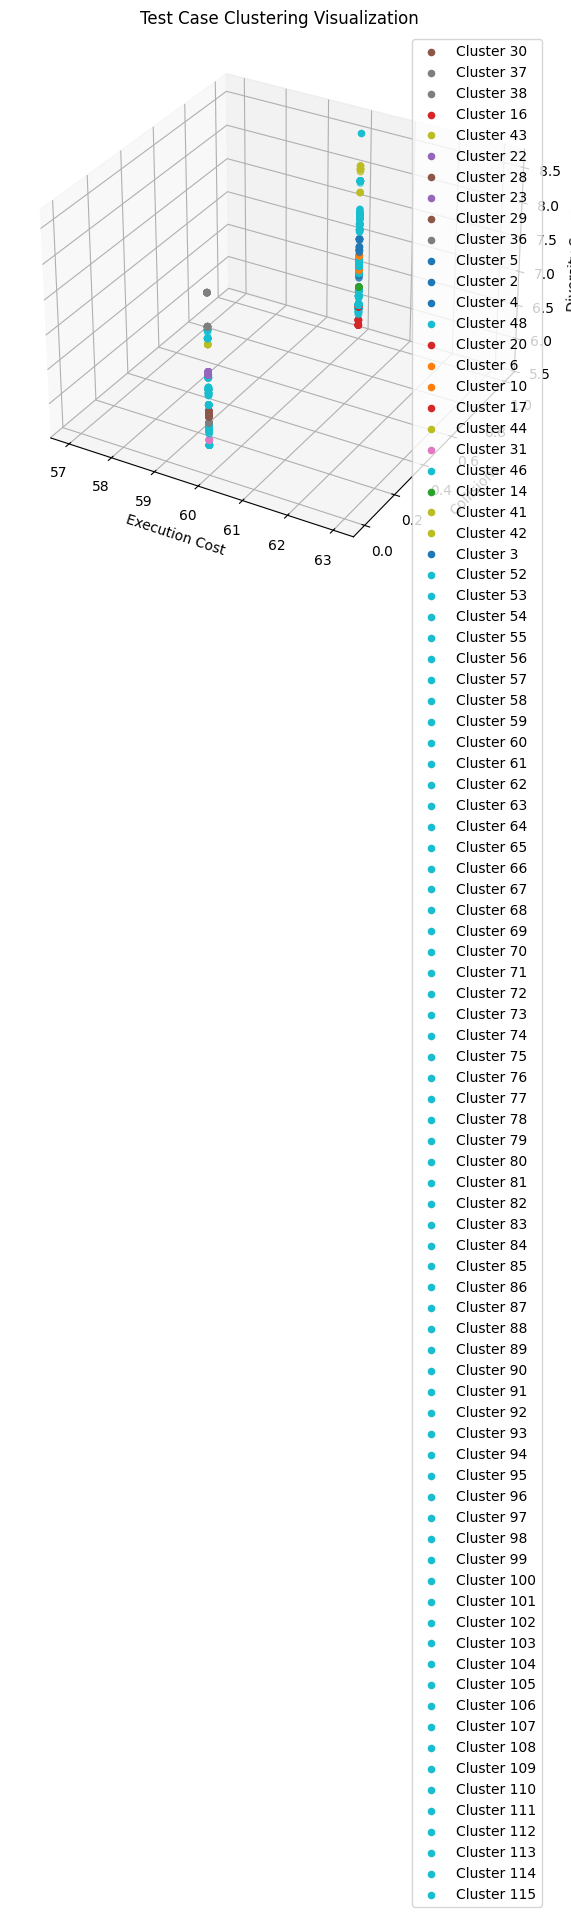

In [4]:
clusters_list = list()

# Normalize data
# data = np.column_stack(60,faults_dictionary,test_cases_stmt_cov)
data = np.column_stack((test_cases_costs,collisions, div_scores))
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

num_clusters = 50
    
max_cluster_dim = 7

# Step 2: Perform K-Means Clustering
start = time.time()
linkage_matrix = linkage(normalized_data, method='ward')
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Organize test cases by cluster
clustered_data = defaultdict(list)
for idx, cluster_id in enumerate(clusters):
    clustered_data[cluster_id].append(idx)

# Process clusters to ensure none exceed max_cluster_dim
new_cluster_id = max(clustered_data.keys()) + 1  # Start new IDs after existing ones
to_add = []  # Collect new smaller clusters

for cluster_id, elements in list(clustered_data.items()):  # Avoid modifying dict during iteration
    if len(elements) > max_cluster_dim:
        num_splits = -(-len(elements) // max_cluster_dim)  # Ceiling division to get the required number of splits
        split_size = -(-len(elements) // num_splits)  # Recalculate to distribute elements evenly
        
        # Split while keeping sizes balanced
        parts = [elements[i:i + split_size] for i in range(0, len(elements), split_size)]
        
        # Ensure all new clusters are within max_cluster_dim
        for part in parts:
            if len(part) > max_cluster_dim:
                raise ValueError(f"A split cluster still exceeds max_cluster_dim ({len(part)} > {max_cluster_dim})!")

        # Add new parts to the new clusters
        to_add.extend(parts)

        # Remove original large cluster
        del clustered_data[cluster_id]

# Assign new IDs to split parts
for part in to_add:
    if part:  # Only add if the part is non-empty
        clustered_data[new_cluster_id] = part
        new_cluster_id += 1
end = time.time()
print("SelectQAOA Decomposition Time(ms): " + str((end-start)*1000))

clusters_list = clustered_data

### QUESTO E' SOLO PER CAPIRE COSA SUCCEDE AL INTERNO; NON E' CRITICO
# Step 3: Calculate the metrics for each cluster and validate
cluster_metrics = {}
for cluster_id in clustered_data.keys():
    tot_cluster_exec_cost = 0
    tot_cluster_collisions = 0
    tot_cluster_div_score = 0
    
    for test_case in clustered_data[cluster_id]:
        tot_cluster_exec_cost += test_cases_costs[test_case]
        tot_cluster_collisions += collisions[test_case]
        tot_cluster_div_score += div_scores[test_case]
        
    cluster_metrics[cluster_id] = {
        "tot_exec_cost": tot_cluster_exec_cost,
        "tot_cluster_collisions": tot_cluster_collisions,
        "tot_cluster_div_score": tot_cluster_div_score
    }
    
    print(f"Cluster {cluster_id + 1} metrics:")
    print(f"Test Cases: {clustered_data[cluster_id]}")
    print(f" - Num. Test Cases: {len(clustered_data[cluster_id]):.2f}")
    print(f" - Execution Cost: {tot_cluster_exec_cost:.2f}")
    print(f" - Collisions: {tot_cluster_collisions}") # Numero collisioni rilevate nel cluster
    print(f" - Total Diversity Score: {tot_cluster_div_score}\n")

for cluster_id in clustered_data.keys():
    print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))

print("======================================================================================")

for cluster_id in clustered_data.keys():
    if len(clustered_data[cluster_id]) > max_cluster_dim:
        print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))

# Plotting the clusters in 3D space
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extracting data for plotting
exec_costs = np.array(test_cases_costs)
colisions_for_plotting = np.array(collisions)
div_scores_for_plotting = np.array(div_scores)

# Plot each cluster with a different color
colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters
for cluster_id in clustered_data.keys():
    cluster_indices = clustered_data[cluster_id]
    
    # Plot each cluster's points
    ax.scatter(
        exec_costs[cluster_indices],
        colisions_for_plotting[cluster_indices],
        div_scores_for_plotting[cluster_indices], 
        color=colors(cluster_id), 
        label=f"Cluster {cluster_id + 1}"
    )

# Label the axes
ax.set_xlabel("Execution Cost")
ax.set_ylabel("Collisions")
ax.set_zlabel("Diversity Scores")
ax.legend()
ax.set_title("Test Case Clustering Visualization")

# Display the plot
plt.show()
    
# print(clusters_list)


In [5]:
def make_linear_terms(cluster_test_cases, alpha):
    """Making the linear terms of QUBO"""
    estimated_costs = []

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for test_case in cluster_test_cases:
        # estimated_costs.append((alpha * (test_cases_costs[sir_program][test_case]/max_cost)) - (1 - alpha) * faults_dictionary[sir_program][test_case])
        estimated_costs.append((alpha/3) - (alpha / 3) * collisions[test_case] - ((alpha/3) * div_scores[test_case]))
    
    return np.array(estimated_costs)    

In [6]:
def create_QUBO_problem(linear_terms):
    """This function is the one that has to encode the QUBO problem that QAOA will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = QuadraticProgram()
    
    for i in range(0,len(linear_terms)):
        qubo.binary_var('x%s' % (i))

    qubo.minimize(linear=linear_terms)

    return qubo


In [7]:
penalties_list = []

#to get a QUBO problem from a quadratic problem with constraints, we have to insert those constraints into the Hamiltonian to solve (which is the one encoded by the QUBO problem). When we insert constraint into the Hamiltonian, we have to specify also penalties
max_penalty = 0

cost = alpha - (1 - alpha) * collisions[0]
if cost > max_penalty:
    max_penalty = cost
    
penalties_list = max_penalty + 1

In [8]:
qubos_list = list()
converter = QuadraticProgramToQubo()

print(f"Cluster's list: {clusters_list}")

#make a dictionary that saves, for each program, the correspondent QUBO
for cluster_id in clusters_list:
    print("Cluster ID: " + str(cluster_id))
    variables = []
    
    for idx in range(0, len(clusters_list[cluster_id])):
        variables.append(idx)
        
    linear_terms = make_linear_terms(clusters_list[cluster_id], alpha)
    qubo = create_QUBO_problem(linear_terms)
    qubos_list.append(qubo)
    
    print(qubo)
    print("/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/")
    print("======================================================================================")

Cluster's list: defaultdict(<class 'list'>, {np.int32(29): [2, 4, 161, 405, 444, 483, 486], np.int32(36): [10, 293, 360, 414, 445, 492], np.int32(37): [12, 110, 136, 140, 269, 276, 312], np.int32(15): [13, 129, 229, 286, 382], np.int32(42): [16, 65, 267, 307, 426, 434], np.int32(21): [20, 28, 195, 319, 321, 358, 393], np.int32(27): [31, 108, 415, 417], np.int32(22): [34, 264, 298, 346, 379, 442, 493], np.int32(28): [44, 299, 306, 333, 406, 443, 470], np.int32(35): [45, 242, 354, 366, 480], np.int32(4): [48, 81, 218, 338], np.int32(1): [55, 178, 280, 324, 335, 390], np.int32(3): [60, 145, 281, 325, 355, 463], np.int32(47): [64, 99, 186, 221, 233, 350, 357], np.int32(19): [70, 71, 168, 251, 344], np.int32(5): [84, 112, 404, 413, 466, 471], np.int32(9): [91, 340, 416, 419], np.int32(16): [135, 200, 227, 247, 372, 496], np.int32(43): [162, 494], np.int32(30): [179, 249, 309, 327, 330], np.int32(45): [297], np.int32(13): [322, 409, 412, 476], np.int32(40): [326, 361, 369, 383], np.int32(41)

In [10]:
# TODO Chiedere al professore
# def covered_lines(sir_program,test_cases_list):
#     """Number of covered lines (no redundancy)"""
#     covered_lines = set()
#     
#     for test_case in test_cases_list:
#         try:
#             for covered_line in test_coverage_line_by_line[sir_program][test_case]:
#                 covered_lines.add(covered_line)
#         except:
#             continue
#     
#     return len(covered_lines)
# 
# def build_pareto_front(sir_program,selected_tests):
#     """This method builds the pareto front additionally from a sub test suite solution"""
#     pareto_front = []
#     max_fault_coverage = 0
#     max_stmt_coverage = 0
#     
#     for index in range(1,len(selected_tests)+1):
#         #exract the first index selected tests
#         candidate_solution = selected_tests[:index]
#         candidate_solution_fault_coverage = 0
#         candidate_solution_stmt_coverage = 0
#         for selected_test in candidate_solution:
#             candidate_solution_fault_coverage += faults_dictionary[sir_program][selected_test]
#             candidate_solution_stmt_coverage += covered_lines(sir_program,candidate_solution)
#         #if the actual pareto front dominates the candidate solution, get to the next candidate
#         if max_fault_coverage >= candidate_solution_fault_coverage and max_stmt_coverage >= candidate_solution_stmt_coverage:
#             continue
#         #eventually update the pareto front information
#         if candidate_solution_stmt_coverage > max_stmt_coverage:
#             max_stmt_coverage = candidate_solution_stmt_coverage
#         if candidate_solution_fault_coverage > max_fault_coverage:
#             max_fault_coverage = candidate_solution_fault_coverage
#         #add the candidate solution to the pareto front
#         pareto_front.append(candidate_solution)
#     
#     return pareto_front

## Optimal Multi-Objective SelectQAOA Depth

First, we want to analyze whether the depth of the circuit of QAOA affects SelectQAOA. To do this, we have executed 10 independent times SelectQAOA on an IDEAL QAOA simulator for different depth values (1, 2, 4, 8, and 16) for each of the examined SIR programs. Then, we applied the Kruskal-Wallis H-test, to see if SelectQAOA behaves differently with different depth values. Finally, we used the Vargha-Delaney's $\hat{A}_{12}$ effect size to estimate the differences between the observations and identify the best configuration for the depth parameter.


## Statevector Simulator
The **Statevector Simulator** in Qiskit Aer is a high-precision quantum circuit simulator that represents the full quantum state of a system. In particular, it is a literal state vector or density matrix in a linear algebra sense, to obtain an exact simulation with no involved noise that applies the necessary rounding when performing floating-point operations. It is useful for **simulating ideal quantum circuits** without noise, decoherence, or measurement effects.


In [9]:
ideal_sampler = AerSampler()
ideal_sampler.options.shots = None

#I want to run the sampler 10 times to get different results for each sir program
qaoa = QAOA(sampler=ideal_sampler, optimizer=COBYLA(maxiter=500), reps=1)
#the fronts will be saved into files
file_path = "results/selectqaoa/statevector_sim/single_run_result.json"
json_data = {}
response = None
qpu_run_times = []
pareto_fronts_building_times = []
final_selected_tests = []
cluster_dict_index = 0

for qubo in qubos_list:
    print("QUBO Problem: " + str(qubo) + "\n Cluster Number: " + str(cluster_dict_index))
    print("Cluster's Test Cases: " +str(list(clusters_list.values())[cluster_dict_index]))
    #for each iteration get the result
    operator, offset = qubo.to_ising()
    print("Linear QUBO: " + str(qubo))
    #for each iteration get the result
    s = time.time()
    qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
    e = time.time()
    #print("QAOA Result: " + str(qaoa_result))
    qpu_run_times.append((e - s) * 1000)
    
    eigenstate = qaoa_result.eigenstate
    most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]

    # Convert to bitstring format
    if isinstance(most_likely, int):
        n = qubo.get_num_binary_vars()
        bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
    elif isinstance(most_likely, str):
        bitstring = [int(b) for b in most_likely[::-1]]
    else:
        raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
    
    indexes_selected_tests = [index for index, value in enumerate(bitstring) if value == 1]
    print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
    selected_tests = []
    for index in indexes_selected_tests:
        selected_tests.append(list(clusters_list.values())[cluster_dict_index][index])
    print("Selected tests: " + str(selected_tests))
    # print("Experiment Number: " + str(i))
    cluster_dict_index += 1
    for selected_test in selected_tests:
        if selected_test not in final_selected_tests:
            final_selected_tests.append(selected_test)
            
# i += 1
#now we have to build the pareto front
print("Final Selected Test Cases: " + str(final_selected_tests))
print("Length of the final list of selected test cases: " + str(len(final_selected_tests)))

## TODO Da capire con il professore se ci dobbiamo fermarci a questo
# start = time.time()
# pareto_front = build_pareto_front(sir_program, final_selected_tests)
# end = time.time()
# json_data["pareto_front_" + str(i)] = pareto_front
# pareto_front_building_time = (end - start) * 1000
# pareto_fronts_building_times.append(pareto_front_building_time)

#compute the average time needed for the construction of a pareto frontier and run time
mean_qpu_run_time = statistics.mean(qpu_run_times)
# mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
json_data["all_qpu_run_times(ms)"] = qpu_run_times
json_data["final_selected_tests"] = final_selected_tests
# json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

with open(file_path, "w") as file:
    json.dump(json_data, file)


QUBO Problem: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
 Cluster Number: 0
Cluster's Test Cases: [2, 4, 161, 405, 444, 483, 486]
Linear QUBO: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
Indexes of selected tests to convert. [0, 1, 2, 3, 4, 5, 6]
Selected tests: [2, 4, 161, 405, 444, 483, 486]
QUBO Problem: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282153865*x2 - 1.1826205282153865*x3 - 1.1826205282153865*x4 - 1.1826205282153865*x5 (6 variables, 0 constraints, '')
 Cluster Number: 1
Cluster's Test Cases: [10, 293, 360, 414, 445, 492]
Linear QUBO: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282153865*x2 - 1.1826205

## Kruskal-Wallis H Test

The **Kruskal-Wallis H test** is a **non-parametric** statistical test used to determine whether **three or more independent groups** come from the same population. It is an extension of the **Mann-Whitney U test** for multiple groups and serves as a non-parametric alternative to **one-way ANOVA**.

- **Null Hypothesis (\(H_0\))**: The samples come from the same distribution (no significant difference between groups).
- **Alternative Hypothesis (\(H_A\))**: At least one group differs significantly from the others.

- A **p-value** is computed to assess statistical significance:
  - **If \( p > 0.05 \)** → Fail to reject \( H_0 \) → Groups may come from the same distribution.
  - **If \( p < 0.05 \)** → Reject \( H_0 \) → At least one group differs significantly.

## Vargha-Delaney's $\hat{A}_{12}$ Effect Size

The **Vargha-Delaney $\hat{A}_{12}$ effect size** is a non-parametric measure used to compare two distributions. It quantifies the probability that a randomly chosen value from one group ( X ) is **greater** than a randomly chosen value from another group ( Y ). It is particularly useful for analyzing differences in performance between two methods, conditions, or datasets.
- **$\hat{A}_{12}$ = 0.5**: Both groups have similar distributions.
- **$\hat{A}_{12}$ > 0.5**: Values in \( X \) tend to be larger than those in \( Y \).
- **$\hat{A}_{12}$ < 0.5**: Values in \( Y \) tend to be larger than those in \( X \).

In [ ]:
# TODO Chiedere al professore
# def total_cost(sir_program,solution):
#     """Total execution cost of the sub suite"""
#     solution_cost = 0
#     
#     for test_case in solution:
#         try:
#             solution_cost += test_cases_costs[sir_program][test_case]
#         except:
#             continue
# 
#     return solution_cost
#         
# def total_coverage(sir_program,solution):
#     """Number of covered lines (no redundancy)"""
#     covered_lines = set()
#     
#     for test_case in solution:
#         try:
#             for covered_line in test_coverage_line_by_line[sir_program][test_case]:
#                 covered_lines.add(covered_line)
#         except:
#             continue
#     
#     return len(covered_lines)
#     
# def total_faults(sir_program,solution):
#     """Number of covered faults"""
#     covered_faults = 0
#     
#     for test_case in solution:
#         try:
#             covered_faults += faults_dictionary[sir_program][test_case]
#         except:
#             continue
#     
#     return covered_faults
# 
# def pareto_dominance(tuple1, tuple2):
#     """This method returns if tuple1 dominates tuple2"""
#     # Check if all conditions are satisfied
#     dominates = (
#         (tuple2[0] <= tuple1[0]) and 
#         (tuple2[1] >= tuple1[1]) and 
#         (tuple2[2] >= tuple1[2])
#     )
#     
#     # Check if at least one condition is strict
#     strict = (
#         (tuple2[0] < tuple1[0]) or 
#         (tuple2[1] > tuple1[1]) or 
#         (tuple2[2] > tuple1[2])
#     )
#     
#     # Return 1 if the second tuple dominates the first, otherwise 0
#     return 1 if dominates and strict else 0

In [ ]:
# TODO Chiedere al professore
# #here we make the same but for each of the fronts built by SelectQA and DIV-GA
# 
# #the following 2 lists will contain much tuples as solutions in each of the 10 pareto fronts
# #each tuple represent the fitness value for each solution
# json_data = {"flex":{"statevector_sim_1":[],"statevector_sim_2":[],"statevector_sim_4":[],"statevector_sim_8":[],"statevector_sim_16":[]},"grep":{"statevector_sim_1":[],"statevector_sim_2":[],"statevector_sim_4":[],"statevector_sim_8":[],"statevector_sim_16":[]},"gzip":{"statevector_sim_1":[],"statevector_sim_2":[],"statevector_sim_4":[],"statevector_sim_8":[],"statevector_sim_16":[]},"sed":{"statevector_sim_1":[],"statevector_sim_2":[],"statevector_sim_4":[],"statevector_sim_8":[],"statevector_sim_16":[]}}
# normal_dist = True
# 
# qaoa_statevector_pareto_vectors_1 = []
# qaoa_statevector_pareto_vectors_2 = []
# qaoa_statevector_pareto_vectors_4 = []
# qaoa_statevector_pareto_vectors_8 = []
# qaoa_statevector_pareto_vectors_16 = []
# 
# for index in range(0,10):
#     # Load the JSON file
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-1.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_statevector_pareto_vectors_1.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_statevector_pareto_vectors_1))
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-2.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_statevector_pareto_vectors_2.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_statevector_pareto_vectors_2))
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-4.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_statevector_pareto_vectors_4.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_statevector_pareto_vectors_4))
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-8.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_statevector_pareto_vectors_8.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_statevector_pareto_vectors_8))
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-16.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_statevector_pareto_vectors_16.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_noise2_pareto_vectors))
# 
# #once we have the pareto vectors from each pareto front obtained by each run, we extract 
# #just the solution not dominated by anyone else
# 
# total_fronts = [qaoa_statevector_pareto_vectors_1,qaoa_statevector_pareto_vectors_2,qaoa_statevector_pareto_vectors_4,qaoa_statevector_pareto_vectors_8,qaoa_statevector_pareto_vectors_16]
# reference_pareto = []
# portions = [0,0,0,0,0]
# 
# # get the reference frontier
# for index, front1 in enumerate(total_fronts):
#     for front_solution1 in front1:
#         is_dominated = 0
#         other_fronts = total_fronts[:index] + total_fronts[index+1:]
#         for front2 in other_fronts:
#             for front_solution2 in front2:
#                 if pareto_dominance(front_solution1,front_solution2):
#                     is_dominated = 1
#                     break
#             if is_dominated:
#                 break
#         if not is_dominated:
#             reference_pareto.append(front_solution1)
#             portions[index] = portions[index] + 1
# 
# print(portions)
# # For SelectQA and DIV-GA we want to compute, for each of the 10 iterations, how many of the solutions of the i-th pareto front were selected by the reference front
# 
# qaoa_statevector_non_dominated_values_1 = []
# qaoa_statevector_non_dominated_values_2 = []
# qaoa_statevector_non_dominated_values_4 = []
# qaoa_statevector_non_dominated_values_8 = []
# qaoa_statevector_non_dominated_values_16 = []
# 
# for index in range(0,10):
#     #print("Iteratrion: " + str(index))
#     
#     qaoa_statevector_non_dominated_1 = 0
#     qaoa_statevector_non_dominated_2 = 0
#     qaoa_statevector_non_dominated_4 = 0
#     qaoa_statevector_non_dominated_8 = 0
#     qaoa_statevector_non_dominated_16 = 0
#     
#     # Load the JSON file
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-1.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     for front_solution in qaoa_pareto_front:
#         if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#             qaoa_statevector_non_dominated_1 += 1
#     
#     qaoa_statevector_non_dominated_values_1.append(qaoa_statevector_non_dominated_1)
#     #print(qaoa_statevector_non_dominated_1)
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-2.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     for front_solution in qaoa_pareto_front:
#         if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#             qaoa_statevector_non_dominated_2 += 1
#     
#     qaoa_statevector_non_dominated_values_2.append(qaoa_statevector_non_dominated_2)
#     #print(qaoa_statevector_non_dominated_1)
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-4.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     for front_solution in qaoa_pareto_front:
#         if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#             qaoa_statevector_non_dominated_4 += 1
#     
#     qaoa_statevector_non_dominated_values_4.append(qaoa_statevector_non_dominated_4)
#     #print(qaoa_statevector_non_dominated_4)
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-8.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     for front_solution in qaoa_pareto_front:
#         if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#             qaoa_statevector_non_dominated_8 += 1
#     
#     qaoa_statevector_non_dominated_values_8.append(qaoa_statevector_non_dominated_8)
#     #print(qaoa_statevector_non_dominated_4)
#     
#     with open('results/selectqaoa/statevector_sim/' + sir_program + '-data-rep-16.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     for front_solution in qaoa_pareto_front:
#         if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#             qaoa_statevector_non_dominated_16 += 1
#     
#     qaoa_statevector_non_dominated_values_16.append(qaoa_statevector_non_dominated_16)
#     #print(qaoa_statevector_non_dominated_8)
#     
#     print("SelectQAOA Non Dominated Values (Rep 1)")
#     print(qaoa_statevector_non_dominated_values_1)
#     print("SelectQAOA Non Dominated Mean (Rep 1)")
#     print(statistics.mean(qaoa_statevector_non_dominated_values_1))
#     print("SelectQAOA Non Dominated StDev (Rep 1)")
#     print(statistics.stdev(qaoa_statevector_non_dominated_values_1))
#     json_data[sir_program]["statevector_sim_1"] = qaoa_statevector_non_dominated_values_1
#     
#     print("SelectQAOA Non Dominated Values (Rep 2)")
#     print(qaoa_statevector_non_dominated_values_2)
#     print("SelectQAOA Non Dominated Mean (Rep 2)")
#     print(statistics.mean(qaoa_statevector_non_dominated_values_2))
#     print("SelectQAOA Non Dominated StDev (Rep 2)")
#     print(statistics.stdev(qaoa_statevector_non_dominated_values_2))
#     json_data[sir_program]["statevector_sim_2"] = qaoa_statevector_non_dominated_values_2
#     
#     print("SelectQAOA Non Dominated Values (Rep 4)")
#     print(qaoa_statevector_non_dominated_values_4)
#     print("SelectQAOA Non Dominated Mean (Rep 4)")
#     print(statistics.mean(qaoa_statevector_non_dominated_values_4))
#     print("SelectQAOA Non Dominated StDev (Rep 4)")
#     print(statistics.stdev(qaoa_statevector_non_dominated_values_4))
#     json_data[sir_program]["statevector_sim_4"] = qaoa_statevector_non_dominated_values_4
#     
#     print("SelectQAOA Non Dominated Values (Rep 8)")
#     print(qaoa_statevector_non_dominated_values_8)
#     print("SelectQAOA Non Dominated Mean (Rep 8)")
#     print(statistics.mean(qaoa_statevector_non_dominated_values_8))
#     print("SelectQAOA Non Dominated StDev (Rep 8)")
#     print(statistics.stdev(qaoa_statevector_non_dominated_values_8))
#     json_data[sir_program]["statevector_sim_8"] = qaoa_statevector_non_dominated_values_8
#     
#     print("SelectQAOA Non Dominated Values (Rep 16)")
#     print(qaoa_statevector_non_dominated_values_16)
#     print("SelectQAOA Non Dominated Mean (Rep 16)")
#     print(statistics.mean(qaoa_statevector_non_dominated_values_16))
#     print("SelectQAOA Non Dominated StDev (Rep 16)")
#     print(statistics.stdev(qaoa_statevector_non_dominated_values_16))
#     json_data[sir_program]["statevector_sim_16"] = qaoa_statevector_non_dominated_values_16
#     
#     print(json_data)
#         
#     if normal_dist:
#         lists = [qaoa_statevector_non_dominated_values_1,qaoa_statevector_non_dominated_values_2,qaoa_statevector_non_dominated_values_4,qaoa_statevector_non_dominated_values_8,qaoa_statevector_non_dominated_values_16]
# 
#         # we are interested in knowing if the obtained sequences are normally distributed to decide what statistical test we should apply
#         for i, list in enumerate(lists, start=1):
#             stat, p_value = shapiro(list)
#             #print(f"List {i}: Statistic = {stat:.5f}, P-value = {p_value:.5f}")
#             
#             # check if the sequence is normally distributed (using 0.05 as threshold)
#             if p_value <= 0.05:
#                 #print(f"List {i} NOT seems to be normally distributed (p-value = {p_value:.5f})")
#                 normal_dist = False
#                 
#     if normal_dist:
#         print("Values all normally distributed")
#     else:
#         print("Values not normally distributed")
# 
#     normal_dist = False
# 
# with open("statevector_multi_obj_frontiers_eval.json", "w") as file:
#     json.dump(json_data, file)

In [ ]:
"""
[5415, 5440, 5425, 5440, 5430]
SelectQAOA Non Dominated Values (Rep 1)
[540, 540, 545, 540, 545, 540, 540, 545, 540, 540]
SelectQAOA Non Dominated Mean (Rep 1)
541.5
SelectQAOA Non Dominated StDev (Rep 1)
2.41522945769824
SelectQAOA Non Dominated Values (Rep 2)
[540, 545, 545, 545, 545, 545, 540, 545, 545, 545]
SelectQAOA Non Dominated Mean (Rep 2)
544
SelectQAOA Non Dominated StDev (Rep 2)
2.1081851067789197
SelectQAOA Non Dominated Values (Rep 4)
[540, 545, 545, 545, 540, 540, 545, 545, 540, 540]
SelectQAOA Non Dominated Mean (Rep 4)
542.5
SelectQAOA Non Dominated StDev (Rep 4)
2.6352313834736494
SelectQAOA Non Dominated Values (Rep 8)
[545, 545, 540, 540, 545, 545, 545, 545, 545, 545]
SelectQAOA Non Dominated Mean (Rep 8)
544
SelectQAOA Non Dominated StDev (Rep 8)
2.1081851067789197
SelectQAOA Non Dominated Values (Rep 16)
[545, 545, 540, 545, 540, 540, 545, 545, 540, 545]
SelectQAOA Non Dominated Mean (Rep 16)
543
SelectQAOA Non Dominated StDev (Rep 16)
2.581988897471611
{'flex': {'statevector_sim_1': [540, 540, 545, 540, 545, 540, 540, 545, 540, 540], 'statevector_sim_2': [540, 545, 545, 545, 545, 545, 540, 545, 545, 545], 'statevector_sim_4': [540, 545, 545, 545, 540, 540, 545, 545, 540, 540], 'statevector_sim_8': [545, 545, 540, 540, 545, 545, 545, 545, 545, 545], 'statevector_sim_16': [545, 545, 540, 545, 540, 540, 545, 545, 540, 545]}, 'grep': {'statevector_sim_1': [], 'statevector_sim_2': [], 'statevector_sim_4': [], 'statevector_sim_8': [], 'statevector_sim_16': []}, 'gzip': {'statevector_sim_1': [], 'statevector_sim_2': [], 'statevector_sim_4': [], 'statevector_sim_8': [], 'statevector_sim_16': []}, 'sed': {'statevector_sim_1': [], 'statevector_sim_2': [], 'statevector_sim_4': [], 'statevector_sim_8': [], 'statevector_sim_16': []}}
Values not normally distributed
[3175, 3177, 3192, 3162, 3124]
SelectQAOA Non Dominated Values (Rep 1)
[322, 322, 308, 308, 322, 322, 323, 316, 316, 316]
SelectQAOA Non Dominated Mean (Rep 1)
317.5
SelectQAOA Non Dominated StDev (Rep 1)
5.759050847723665
SelectQAOA Non Dominated Values (Rep 2)
[308, 322, 308, 323, 322, 316, 323, 316, 323, 316]
SelectQAOA Non Dominated Mean (Rep 2)
317.7
SelectQAOA Non Dominated StDev (Rep 2)
5.945119380167605
SelectQAOA Non Dominated Values (Rep 4)
[316, 316, 316, 323, 308, 323, 322, 323, 323, 322]
SelectQAOA Non Dominated Mean (Rep 4)
319.2
SelectQAOA Non Dominated StDev (Rep 4)
5.0508525133002165
SelectQAOA Non Dominated Values (Rep 8)
[322, 308, 316, 316, 322, 316, 323, 308, 323, 308]
SelectQAOA Non Dominated Mean (Rep 8)
316.2
SelectQAOA Non Dominated StDev (Rep 8)
6.338594306135847
SelectQAOA Non Dominated Values (Rep 16)
[308, 308, 316, 308, 316, 322, 308, 322, 308, 308]
SelectQAOA Non Dominated Mean (Rep 16)
312.4
SelectQAOA Non Dominated StDev (Rep 16)
6.022181221672648
{'flex': {'statevector_sim_1': [540, 540, 545, 540, 545, 540, 540, 545, 540, 540], 'statevector_sim_2': [540, 545, 545, 545, 545, 545, 540, 545, 545, 545], 'statevector_sim_4': [540, 545, 545, 545, 540, 540, 545, 545, 540, 540], 'statevector_sim_8': [545, 545, 540, 540, 545, 545, 545, 545, 545, 545], 'statevector_sim_16': [545, 545, 540, 545, 540, 540, 545, 545, 540, 545]}, 'grep': {'statevector_sim_1': [322, 322, 308, 308, 322, 322, 323, 316, 316, 316], 'statevector_sim_2': [308, 322, 308, 323, 322, 316, 323, 316, 323, 316], 'statevector_sim_4': [316, 316, 316, 323, 308, 323, 322, 323, 323, 322], 'statevector_sim_8': [322, 308, 316, 316, 322, 316, 323, 308, 323, 308], 'statevector_sim_16': [308, 308, 316, 308, 316, 322, 308, 322, 308, 308]}, 'gzip': {'statevector_sim_1': [], 'statevector_sim_2': [], 'statevector_sim_4': [], 'statevector_sim_8': [], 'statevector_sim_16': []}, 'sed': {'statevector_sim_1': [], 'statevector_sim_2': [], 'statevector_sim_4': [], 'statevector_sim_8': [], 'statevector_sim_16': []}}
Values not normally distributed
[1490, 1655, 1651, 1322, 1488]
SelectQAOA Non Dominated Values (Rep 1)
[165, 166, 1, 166, 165, 165, 166, 165, 166, 165]
SelectQAOA Non Dominated Mean (Rep 1)
149
SelectQAOA Non Dominated StDev (Rep 1)
52.004273328683716
SelectQAOA Non Dominated Values (Rep 2)
[165, 165, 165, 166, 166, 166, 166, 165, 165, 166]
SelectQAOA Non Dominated Mean (Rep 2)
165.5
SelectQAOA Non Dominated StDev (Rep 2)
0.5270462766947299
SelectQAOA Non Dominated Values (Rep 4)
[165, 165, 165, 165, 165, 165, 165, 165, 166, 165]
SelectQAOA Non Dominated Mean (Rep 4)
165.1
SelectQAOA Non Dominated StDev (Rep 4)
0.31622776601683794
SelectQAOA Non Dominated Values (Rep 8)
[165, 165, 165, 165, 165, 165, 165, 165, 1, 1]
SelectQAOA Non Dominated Mean (Rep 8)
132.2
SelectQAOA Non Dominated StDev (Rep 8)
69.14847150234856
SelectQAOA Non Dominated Values (Rep 16)
[165, 165, 165, 165, 165, 1, 165, 166, 166, 165]
SelectQAOA Non Dominated Mean (Rep 16)
148.8
SelectQAOA Non Dominated StDev (Rep 16)
51.933290543414124
{'flex': {'statevector_sim_1': [540, 540, 545, 540, 545, 540, 540, 545, 540, 540], 'statevector_sim_2': [540, 545, 545, 545, 545, 545, 540, 545, 545, 545], 'statevector_sim_4': [540, 545, 545, 545, 540, 540, 545, 545, 540, 540], 'statevector_sim_8': [545, 545, 540, 540, 545, 545, 545, 545, 545, 545], 'statevector_sim_16': [545, 545, 540, 545, 540, 540, 545, 545, 540, 545]}, 'grep': {'statevector_sim_1': [322, 322, 308, 308, 322, 322, 323, 316, 316, 316], 'statevector_sim_2': [308, 322, 308, 323, 322, 316, 323, 316, 323, 316], 'statevector_sim_4': [316, 316, 316, 323, 308, 323, 322, 323, 323, 322], 'statevector_sim_8': [322, 308, 316, 316, 322, 316, 323, 308, 323, 308], 'statevector_sim_16': [308, 308, 316, 308, 316, 322, 308, 322, 308, 308]}, 'gzip': {'statevector_sim_1': [165, 166, 1, 166, 165, 165, 166, 165, 166, 165], 'statevector_sim_2': [165, 165, 165, 166, 166, 166, 166, 165, 165, 166], 'statevector_sim_4': [165, 165, 165, 165, 165, 165, 165, 165, 166, 165], 'statevector_sim_8': [165, 165, 165, 165, 165, 165, 165, 165, 1, 1], 'statevector_sim_16': [165, 165, 165, 165, 165, 1, 165, 166, 166, 165]}, 'sed': {'statevector_sim_1': [], 'statevector_sim_2': [], 'statevector_sim_4': [], 'statevector_sim_8': [], 'statevector_sim_16': []}}
Values not normally distributed
[711, 869, 236, 269, 319]
SelectQAOA Non Dominated Values (Rep 1)
[234, 237, 14, 39, 12, 39, 236, 237, 34, 237]
SelectQAOA Non Dominated Mean (Rep 1)
131.9
SelectQAOA Non Dominated StDev (Rep 1)
110.31314014608091
SelectQAOA Non Dominated Values (Rep 2)
[34, 12, 237, 237, 12, 39, 12, 39, 12, 236]
SelectQAOA Non Dominated Mean (Rep 2)
87
SelectQAOA Non Dominated StDev (Rep 2)
103.87920335124296
SelectQAOA Non Dominated Values (Rep 4)
[12, 12, 12, 34, 12, 237, 39, 237, 39, 34]
SelectQAOA Non Dominated Mean (Rep 4)
66.8
SelectQAOA Non Dominated StDev (Rep 4)
90.45907607556272
SelectQAOA Non Dominated Values (Rep 8)
[237, 34, 39, 34, 34, 39, 34, 39, 237, 34]
SelectQAOA Non Dominated Mean (Rep 8)
76.1
SelectQAOA Non Dominated StDev (Rep 8)
84.83244924228255
SelectQAOA Non Dominated Values (Rep 16)
[39, 34, 237, 12, 237, 237, 39, 237, 39, 12]
SelectQAOA Non Dominated Mean (Rep 16)
112.3
SelectQAOA Non Dominated StDev (Rep 16)
107.79100147971536
{'flex': {'statevector_sim_1': [540, 540, 545, 540, 545, 540, 540, 545, 540, 540], 'statevector_sim_2': [540, 545, 545, 545, 545, 545, 540, 545, 545, 545], 'statevector_sim_4': [540, 545, 545, 545, 540, 540, 545, 545, 540, 540], 'statevector_sim_8': [545, 545, 540, 540, 545, 545, 545, 545, 545, 545], 'statevector_sim_16': [545, 545, 540, 545, 540, 540, 545, 545, 540, 545]}, 'grep': {'statevector_sim_1': [322, 322, 308, 308, 322, 322, 323, 316, 316, 316], 'statevector_sim_2': [308, 322, 308, 323, 322, 316, 323, 316, 323, 316], 'statevector_sim_4': [316, 316, 316, 323, 308, 323, 322, 323, 323, 322], 'statevector_sim_8': [322, 308, 316, 316, 322, 316, 323, 308, 323, 308], 'statevector_sim_16': [308, 308, 316, 308, 316, 322, 308, 322, 308, 308]}, 'gzip': {'statevector_sim_1': [165, 166, 1, 166, 165, 165, 166, 165, 166, 165], 'statevector_sim_2': [165, 165, 165, 166, 166, 166, 166, 165, 165, 166], 'statevector_sim_4': [165, 165, 165, 165, 165, 165, 165, 165, 166, 165], 'statevector_sim_8': [165, 165, 165, 165, 165, 165, 165, 165, 1, 1], 'statevector_sim_16': [165, 165, 165, 165, 165, 1, 165, 166, 166, 165]}, 'sed': {'statevector_sim_1': [234, 237, 14, 39, 12, 39, 236, 237, 34, 237], 'statevector_sim_2': [34, 12, 237, 237, 12, 39, 12, 39, 12, 236], 'statevector_sim_4': [12, 12, 12, 34, 12, 237, 39, 237, 39, 34], 'statevector_sim_8': [237, 34, 39, 34, 34, 39, 34, 39, 237, 34], 'statevector_sim_16': [39, 34, 237, 12, 237, 237, 39, 237, 39, 12]}}

"""
#ALWAYS REP=1 wins (never statistically different from others)

## Multi-Objective SelectQAOA Execution
Once we know the optimal configuration of SelectQAOA for each depth value, we can make the executions of all the simulators with their optimal configurations.

## Aer Simulator
The Aer Simulator applies sampling noise to simulate the natural stochasticity property of quantum mechanics. No other perturbations are allowed, but the stochasticity itself is a significant obstacle for many optimization methods.

In [10]:
#I want to run the sampler 30 times to get different results for each sir program
sampling_noise_sampler = AerSampler()
sampling_noise_sampler.options.shots = 2048

qaoa = QAOA(sampler=sampling_noise_sampler, optimizer=COBYLA(500), reps=1)
#the fronts will be saved into files
file_path = "results/selectqaoa/aer_sim/" + QRT_ADAS + "-data.json"
json_data = {}
response = None
qpu_run_times = []

# pareto_fronts_building_times = []

for i in range(experiments):
    final_selected_tests = []
    cluster_dict_index = 0
    
    print("Experiment Number: " + str(i))
    
    for qubo in qubos_list:
        print("QUBO Problem: " + str(qubo) + "\n Cluster Number: " + str(cluster_dict_index))
        print("Cluster's Test Cases: " +str(list(clusters_list.values())[cluster_dict_index]))
        #for each iteration get the result
        operator, offset = qubo.to_ising()
        print("Linear QUBO: " + str(qubo))
        #for each iteration get the result
        s = time.time()
        qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
        e = time.time()
        #print("QAOA Result: " + str(qaoa_result))
        qpu_run_times.append((e - s) * 1000)
        
        eigenstate = qaoa_result.eigenstate
        most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
    
        # Convert to bitstring format
        if isinstance(most_likely, int):
            n = qubo.get_num_binary_vars()
            bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
        elif isinstance(most_likely, str):
            bitstring = [int(b) for b in most_likely[::-1]]
        else:
            raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
        
        indexes_selected_tests = [index for index, value in enumerate(bitstring) if value == 1]
        print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
        selected_tests = []
        for index in indexes_selected_tests:
            selected_tests.append(list(clusters_list.values())[cluster_dict_index][index])
        print("Selected tests: " + str(selected_tests))
        cluster_dict_index += 1
        for selected_test in selected_tests:
            if selected_test not in final_selected_tests:
                final_selected_tests.append(selected_test)
    i+=1
    #now we have to build the pareto front
    print("Final Selected Test Cases: " + str(final_selected_tests))
    print("Length of the final list of selected test cases: " + str(len(final_selected_tests)))
    # start = time.time()
    # pareto_front = build_pareto_front(sir_program, final_selected_tests)
    # end = time.time()
    # json_data["pareto_front_" + str(i)] = pareto_front
    # pareto_front_building_time = (end - start) * 1000
    # pareto_fronts_building_times.append(pareto_front_building_time)

#compute the average time needed for the construction of a pareto frontier and run time
mean_qpu_run_time = statistics.mean(qpu_run_times)
# mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
json_data["all_qpu_run_times(ms)"] = qpu_run_times
# json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

with open(file_path, "w") as file:
    json.dump(json_data, file)


QUBO Problem: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
 Cluster Number: 0
Cluster's Test Cases: [2, 4, 161, 405, 444, 483, 486]
Linear QUBO: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
Indexes of selected tests to convert. [0, 1, 2, 3, 4, 5, 6]
Selected tests: [2, 4, 161, 405, 444, 483, 486]
Experiment Number: 0
QUBO Problem: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282153865*x2 - 1.1826205282153865*x3 - 1.1826205282153865*x4 - 1.1826205282153865*x5 (6 variables, 0 constraints, '')
 Cluster Number: 1
Cluster's Test Cases: [10, 293, 360, 414, 445, 492]
Linear QUBO: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282

## Fake Brisbane Noise Simulator
The **Fake Vigo backend** in Qiskit Aer is a simulated version of IBM Quantum's **real 5-qubit Vigo quantum processor**. It allows users to test quantum circuits in a **realistic noisy environment** introducing **decoherence**.

In [11]:
noise_model = NoiseModel.from_backend(FakeBrisbane())
fake_sampler = AerSampler(backend_options={'noise_model': noise_model})
fake_sampler.options.shots = 2048

#I want to run the sampler 30 times to obtain different results for each sir program
qaoa = QAOA(sampler=fake_sampler, optimizer=COBYLA(500), reps=1)
file_path = "results/selectqaoa/fake_brisbane/" + QRT_ADAS + "-data.json"
json_data = {}
response = None
qpu_run_times = []
# pareto_fronts_building_times = []

for i in range(experiments):
    final_selected_tests = []
    cluster_dict_index = 0
    print("Experiment Number: " + str(i))
    for qubo in qubos_list:
        print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
        print("Cluster's Test Cases: " + str(list(clusters_list.values())[cluster_dict_index]))
        #for each iteration get the result
        operator, offset = qubo.to_ising()
        print("Linear QUBO: " + str(qubo))
        #for each iteration get the result
        s = time.time()
        qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
        e = time.time()
        #print("QAOA Result: " + str(qaoa_result))
        qpu_run_times.append((e - s) * 1000)
        
        eigenstate = qaoa_result.eigenstate
        most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
    
        # Convert to bitstring format
        if isinstance(most_likely, int):
            n = qubo.get_num_binary_vars()
            bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
        elif isinstance(most_likely, str):
            bitstring = [int(b) for b in most_likely[::-1]]
        else:
            raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
        
        indexes_selected_tests = [index for index, value in enumerate(bitstring) if value == 1]
        print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
        selected_tests = []
        for index in indexes_selected_tests:
            selected_tests.append(list(clusters_list.values())[cluster_dict_index][index])
        print("Selected tests: " + str(selected_tests))
        cluster_dict_index += 1
        for selected_test in selected_tests:
            if selected_test not in final_selected_tests:
                final_selected_tests.append(selected_test)
    i+=1
    #now we have to build the pareto front
    print("Final Selected Test Cases: " + str(final_selected_tests))
    print(len(final_selected_tests))
    # start = time.time()
    # pareto_front = build_pareto_front(sir_program, final_selected_tests)
    # end = time.time()
    # json_data["pareto_front_" + str(i)] = pareto_front
    # pareto_front_building_time = (end - start) * 1000
    # pareto_fronts_building_times.append(pareto_front_building_time)

#compute the average time needed for the construction of a pareto frontier and run time
mean_qpu_run_time = statistics.mean(qpu_run_times)
# mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
json_data["all_qpu_run_times(ms)"] = qpu_run_times
# json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

with open(file_path, "w") as file:
    json.dump(json_data, file)


Experiment Number: 0
QUBO Problem: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
Number: 0
Cluster's Test Cases: [2, 4, 161, 405, 444, 483, 486]
Linear QUBO: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
Indexes of selected tests to convert. [0, 1, 2, 3, 4, 5, 6]
Selected tests: [2, 4, 161, 405, 444, 483, 486]
QUBO Problem: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282153865*x2 - 1.1826205282153865*x3 - 1.1826205282153865*x4 - 1.1826205282153865*x5 (6 variables, 0 constraints, '')
Number: 1
Cluster's Test Cases: [10, 293, 360, 414, 445, 492]
Linear QUBO: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282153865*x2 - 1.1826

KeyboardInterrupt: 

## Depolarizing Error Simulator
The **depolarizing noise model** is a common quantum noise model that simulates the effect of random errors occurring in quantum computations. In a **depolarizing channel**, a qubit undergoes a transformation where it has a probability \( p \) of being replaced by a completely mixed state, losing all its quantum coherence.

- **1% noise** simulates near-term quantum hardware with optimized error rates.
- **2% noise** represents moderate errors in typical superconducting quantum processors.
- **5% noise** helps study worst-case scenarios and assess robustness of quantum algorithms.
- Comparing different noise levels allows us to evaluate how quantum circuits **degrade** under varying degrees of decoherence and to **develop error mitigation techniques**.


In [12]:
noise_model = NoiseModel()
error_1 = depolarizing_error(0.01, 1)
error_2 = depolarizing_error(0.01, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

#I want to run the sampler 30 times to obtain different results for each sir program
qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500), reps=1)
#the fronts will be saved into files
file_path = "results/selectqaoa/depolarizing_sim/01/" + QRT_ADAS + "-data.json"
json_data = {}
response = None
qpu_run_times = []

# pareto_fronts_building_times = []

for i in range(experiments):
    final_selected_tests = []
    cluster_dict_index = 0
    for qubo in qubos_list:
        print("Experiment Number: " + str(i))
        print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
        print("Cluster's Test Cases: " + str(list(clusters_list.values())[cluster_dict_index]))
        #for each iteration get the result
        operator, offset = qubo.to_ising()
        print("Linear QUBO: " + str(qubo))
        #for each iteration get the result
        s = time.time()
        qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
        e = time.time()
        #print("QAOA Result: " + str(qaoa_result))
        qpu_run_times.append((e - s) * 1000)
        
        eigenstate = qaoa_result.eigenstate
        most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
    
        # Convert to bitstring format
        if isinstance(most_likely, int):
            n = qubo.get_num_binary_vars()
            bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
        elif isinstance(most_likely, str):
            bitstring = [int(b) for b in most_likely[::-1]]
        else:
            raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
        
        indexes_selected_tests = [index for index, value in enumerate(bitstring) if value == 1]
        print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
        selected_tests = []
        for index in indexes_selected_tests:
            selected_tests.append(list(clusters_list.values())[cluster_dict_index][index])
        print("Selected tests: " + str(selected_tests))
        cluster_dict_index += 1
        for selected_test in selected_tests:
            if selected_test not in final_selected_tests:
                final_selected_tests.append(selected_test)
    i+=1
    #now we have to build the pareto front
    print("Final Selected Test Cases: " + str(final_selected_tests))
    print(len(final_selected_tests))
    # start = time.time()
    # pareto_front = build_pareto_front(sir_program, final_selected_tests)
    # end = time.time()
    # json_data["pareto_front_" + str(i)] = pareto_front
    # pareto_front_building_time = (end - start) * 1000
    # pareto_fronts_building_times.append(pareto_front_building_time)

#compute the average time needed for the construction of a pareto frontier and run time
mean_qpu_run_time = statistics.mean(qpu_run_times)
# mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
json_data["all_qpu_run_times(ms)"] = qpu_run_times
# json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

with open(file_path, "w") as file:
    json.dump(json_data, file)


Experiment Number: 0
QUBO Problem: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
Number: 0
Cluster's Test Cases: [2, 4, 161, 405, 444, 483, 486]
Linear QUBO: minimize -0.8975423658461968*x0 - 0.8975423658461968*x1 - 0.8975423658461968*x2 - 0.8975423658461968*x3 - 0.8975423658461968*x4 - 0.8975423658461968*x5 - 0.8975423658461968*x6 (7 variables, 0 constraints, '')
Indexes of selected tests to convert. [0, 1, 2, 3, 4, 5, 6]
Selected tests: [2, 4, 161, 405, 444, 483, 486]
Experiment Number: 0
QUBO Problem: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205282153865*x2 - 1.1826205282153865*x3 - 1.1826205282153865*x4 - 1.1826205282153865*x5 (6 variables, 0 constraints, '')
Number: 1
Cluster's Test Cases: [10, 293, 360, 414, 445, 492]
Linear QUBO: minimize -1.1826205282153863*x0 - 1.1826205282153865*x1 - 1.1826205


KeyboardInterrupt



In [ ]:
noise_model = NoiseModel()
error_1 = depolarizing_error(0.02, 1)
error_2 = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

#I want to run the sampler 30 times to obtain different results for each sir program
qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500), reps=1)
#the fronts will be saved into files
file_path = "results/selectqaoa/depolarizing_sim/02/" + QRT_ADAS + "-data.json"
json_data = {}
response = None
qpu_run_times = []
# pareto_fronts_building_times = []

for i in range(experiments):
    final_selected_tests = []
    cluster_dict_index = 0
    for qubo in qubos_list:
        print("Experiment Number: " + str(i))
        print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
        print("Cluster's Test Cases: " +str(list(clusters_list.values())[cluster_dict_index]))
        #for each iteration get the result
        operator, offset = qubo.to_ising()
        print("Linear QUBO: " + str(qubo))
        #for each iteration get the result
        s = time.time()
        qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
        e = time.time()
        #print("QAOA Result: " + str(qaoa_result))
        qpu_run_times.append((e - s) * 1000)
        
        eigenstate = qaoa_result.eigenstate
        most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
    
        # Convert to bitstring format
        if isinstance(most_likely, int):
            n = qubo.get_num_binary_vars()
            bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
        elif isinstance(most_likely, str):
            bitstring = [int(b) for b in most_likely[::-1]]
        else:
            raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
        
        indexes_selected_tests = [index for index, value in enumerate(bitstring) if value == 1]
        print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
        selected_tests = []
        for index in indexes_selected_tests:
            selected_tests.append(list(clusters_list.values())[cluster_dict_index][index])
        print("Selected tests: " + str(selected_tests))
        cluster_dict_index += 1
        for selected_test in selected_tests:
            if selected_test not in final_selected_tests:
                final_selected_tests.append(selected_test)
    i+=1
    #now we have to build the pareto front
    print("Final Selected Test Cases: " + str(final_selected_tests))
    print(len(final_selected_tests))
    # start = time.time()
    # pareto_front = build_pareto_front(sir_program, final_selected_tests)
    # end = time.time()
    # json_data["pareto_front_" + str(i)] = pareto_front
    # pareto_front_building_time = (end - start) * 1000
    # pareto_fronts_building_times.append(pareto_front_building_time)

#compute the average time needed for the construction of a pareto frontier and run time
mean_qpu_run_time = statistics.mean(qpu_run_times)
# mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
json_data["all_qpu_run_times(ms)"] = qpu_run_times
# json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

with open(file_path, "w") as file:
    json.dump(json_data, file)


In [ ]:
noise_model = NoiseModel()
error_1 = depolarizing_error(0.05, 1)
error_2 = depolarizing_error(0.05, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

#I want to run the sampler 30 times to obtain different results for each sir program
qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500), reps=1)
#the fronts will be saved into files
file_path = "results/selectqaoa/depolarizing_sim/05/" + QRT_ADAS + "-data.json"
json_data = {}
response = None
qpu_run_times = []
# pareto_fronts_building_times = []

for i in range(experiments):
    final_selected_tests = []
    cluster_dict_index = 0
    for qubo in qubos_list:
        print("Experiment Number: " + str(i))
        print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
        print("Cluster's Test Cases: " +str(list(clusters_list.values())[cluster_dict_index]))
        #for each iteration get the result
        operator, offset = qubo.to_ising()
        print("Linear QUBO: " + str(qubo))
        #for each iteration get the result
        s = time.time()
        qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
        e = time.time()
        #print("QAOA Result: " + str(qaoa_result))
        qpu_run_times.append((e - s) * 1000)
        
        eigenstate = qaoa_result.eigenstate
        most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
    
        # Convert to bitstring format
        if isinstance(most_likely, int):
            n = qubo.get_num_binary_vars()
            bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
        elif isinstance(most_likely, str):
            bitstring = [int(b) for b in most_likely[::-1]]
        else:
            raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
        
        indexes_selected_tests = [index for index, value in enumerate(bitstring) if value == 1]
        print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
        selected_tests = []
        for index in indexes_selected_tests:
            selected_tests.append(list(clusters_list.values())[cluster_dict_index][index])
        print("Selected tests: " + str(selected_tests))
        cluster_dict_index += 1
        for selected_test in selected_tests:
            if selected_test not in final_selected_tests:
                final_selected_tests.append(selected_test)
    i+=1
    #now we have to build the pareto front
    print("Final Selected Test Cases: " + str(final_selected_tests))
    print(len(final_selected_tests))
    # start = time.time()
    # pareto_front = build_pareto_front(sir_program, final_selected_tests)
    # end = time.time()
    # json_data["pareto_front_" + str(i)] = pareto_front
    # pareto_front_building_time = (end - start) * 1000
    # pareto_fronts_building_times.append(pareto_front_building_time)

#compute the average time needed for the construction of a pareto frontier and run time
mean_qpu_run_time = statistics.mean(qpu_run_times)
# mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
json_data["all_qpu_run_times(ms)"] = qpu_run_times
# json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

with open(file_path, "w") as file:
    json.dump(json_data, file)


## Effectiveness Empirical Evaluations
The four algorithms were evaluated in terms of their **effectiveness**. In particular, we built a **reference Pareto front** made by all the **non-dominated solutions** found by all the algorithms during all ten runs. 

Let $P = \{ P_1, ..., P_l \}$ be the set of \( $l$ \) different Pareto fronts obtained after all the experiment runs by all the evaluated algorithms. The **reference Pareto front** $P_{\text{ref}}$ is defined as follows:


$P_{\text{ref}} \subseteq \bigcup_{i=1}^{l} P_i$


where $\forall p \in P_{\text{ref}}, \nexists q \in P_{\text{ref}}: q > p$. 

Given the reference front, we computed as an **effectiveness metric** the **number of non-dominated solutions**, i.e., the number of non-dominated solutions found by an algorithm selected for the final reference front.

To ensure the empirical reliability of the results, we used the **Mann-Whitney U test** and the **Vargha-Delaney effect size** $\hat{A}_{12}$. The null hypothesis, i.e., there is **no statistically significant difference** between the effectiveness of the algorithms, is rejected if p-values < 0.05.


### The Dunn's Test

The **Kruskal-Wallis H-test** is a non-parametric statistical test used to determine whether there are significant differences between three or more independent groups. However, while the test can indicate that at least one group differs, it does not specify which groups are different from each other.

To address this, we apply **Dunn's Test**, a post-hoc pairwise comparison method that helps identify which specific groups differ. This test compares all possible pairs of groups to determine which ones have statistically significant differences. Since multiple comparisons increase the chance of false positives, Dunn's test is often used with a correction method such as Bonferroni or Holm to adjust p-values. If the adjusted p-value is below the significance threshold (typically 0.05), we conclude that the two compared groups are significantly different.



In [ ]:
#the other sizes are uniform
#this static information can be easily obtained from the pareto .json files

qtcs_flex_pareto_sizes = [187,187,187,187,187,187,187,187,187,187]
divga_flex_pareto_sizes = [140,140,140,140,140,140,140,140,140,140]
qaoa_statevector_flex_pareto_sizes = [447,434,413,409,434,455,446,410,416,427]
qaoa_aer_flex_pareto_sizes = [517,515,518,523,516,518,505,514,518,526]
qaoa_fakevigo_flex_pareto_sizes = [540,540,540,540,540,540,540,539,539,539]
qaoa_fakevigozne_flex_pareto_sizes = [545,541,537,542,539,547,549,541,550,540]
qaoa_noise1_flex_pareto_sizes = [539,540,540,539,540,540,539,539,539,539]
qaoa_noise2_flex_pareto_sizes = [540,539,540,539,540,540,539,540,539,540]
qaoa_noise5_flex_pareto_sizes = [539,539,540,540,540,539,540,540,540,539]
greedy_flex_size = 567

qtcs_grep_pareto_sizes = [229,229,230,229,230,229,230.229,230,230]
divga_grep_pareto_sizes = [70,70,70,70,70,70,70,70,70,70]
qaoa_statevector_grep_pareto_sizes = [485,507,504,505,489,492,489,493,489,470]
qaoa_aer_grep_pareto_sizes = [343,345,343,341,346,345,345,346,340,348]
qaoa_fakevigo_grep_pareto_sizes = [321,321,321,321,321,321,321,321,321,321]
qaoa_fakevigozne_grep_pareto_sizes = [427,430,440,445,450,422,433,440,445,441]
qaoa_noise1_grep_pareto_sizes = [321,321,321,321,321,321,321,321,321,321]
qaoa_noise2_grep_pareto_sizes = [321,321,321,321,321,321,321,321,321,321]
qaoa_noise5_grep_pareto_sizes = [321,321,321,321,321,321,321,321,321,321]
greedy_grep_size = 802

qtcs_gzip_pareto_sizes = [87,86,85,86,87,87,86,87,85,87]
divga_gzip_pareto_sizes = [105,105,105,105,105,105,105,105,105,105]
qaoa_statevector_gzip_pareto_sizes = [137,143,146,144,164,143,157,144,141,169]
qaoa_aer_gzip_pareto_sizes = [147,146,145,146,151,155,155,151,154,156]
qaoa_fakevigo_gzip_pareto_sizes = [168,168,166,169,168,167,167,168,168,167]
qaoa_fakevigozne_gzip_pareto_sizes = [182,183,181,182,189,182,183,178,185,183]
qaoa_noise1_gzip_pareto_sizes = [167,167,167,166,168,167,166,166,168,166]
qaoa_noise2_gzip_pareto_sizes = [166,166,168,167,166,166,166,167,167,166]
qaoa_noise5_gzip_pareto_sizes = [169,167,167,169,168,168,168,165,167,167]
greedy_gzip_size = 199

qtcs_sed_pareto_sizes = [131,131,131,131,131,131,131,131,131,131]
divga_sed_pareto_sizes = [105,62,105,105,102,105,105,97,105,105]
qaoa_statevector_sed_pareto_sizes = [249,241,252,226,245,231,248,241,245,237]
qaoa_aer_sed_pareto_sizes = [260,251,253,263,252,263,260,256,250,253]
qaoa_fakevigo_sed_pareto_sizes = [235,235,236,235,236,236,235,236,236,236]
qaoa_fakevigozne_sed_pareto_sizes = [256,257,249,263,249,259,237,262,253,251]
qaoa_noise1_sed_pareto_sizes = [236,235,235,235,236,236,236,235,236,235]
qaoa_noise2_sed_pareto_sizes = [235,235,236,235,235,236,236,236,236,236]
qaoa_noise5_sed_pareto_sizes = [236,236,235,236,236,235,235,236,236,235]
greedy_sed_size = 356

In [ ]:
#TODO Chiedere al Professore
# # Unpack the tuples for each list
# def unpack_tuples(data):
#     """Unpack the data"""
#     return zip(*data)
# 
# json_data = {"flex":{"statevector_sim":{},"aer_sim":{},"fake_brisbane":{}, "depolarizing_sim/01":{},"depolarizing_sim/02":{},"depolarizing_sim/05":{}},"grep":{"statevector_sim":{},"aer_sim":{},"fake_brisbane":{}, "depolarizing_sim/01":{},"depolarizing_sim/02":{},"depolarizing_sim/05":{}},"gzip":{"statevector_sim":{},"aer_sim":{},"fake_brisbane":{}, "depolarizing_sim/01":{},"depolarizing_sim/02":{},"depolarizing_sim/05":{}},"sed":{"statevector_sim":{},"aer_sim":{},"fake_brisbane":{}, "depolarizing_sim/01":{},"depolarizing_sim/02":{},"depolarizing_sim/05":{}}}
# normal_dist = True
# with open('./results/add-greedy/'+sir_program+'_data.json', 'r') as file:
#     pareto_fronts_json = json.load(file)
# 
# greedy_pareto_front = pareto_fronts_json['pareto_front']
# 
# #each solution of the pareto front is a subset of the test suite
# greedy_pareto_vectors = []
# for front_solution in greedy_pareto_front:
#     #compute the fitness scores of each single solution
#     greedy_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #here we make the same but for each of the fronts built by SelectQA and DIV-GA
# 
# #the following 2 lists will contain much tuples as solutions in each of the 10 pareto fronts
# #each tuple represent the fitness value for each solution
# qtcs_pareto_vectors = []
# divga_pareto_vectors = []
# qaoa_statevector_pareto_vectors = []
# qaoa_aer_pareto_vectors = []
# qaoa_fakevigo_pareto_vectors = []
# qaoa_noise1_pareto_vectors = []
# qaoa_noise2_pareto_vectors = []
# qaoa_noise5_pareto_vectors = []
# 
# for index in range(0,10):
#     # Load the JSON file
#     with open('results/selectqa/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(index)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qtcs_pareto_front:
#         qtcs_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qtcs_pareto_vectors))
#     
#     with open('./results/divga/'+sir_program+'_pareto_fronts_divga.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     divga_pareto_front = pareto_fronts_json[sir_program+'_pareto_front_'+str(index)]
#     for front_solution in divga_pareto_front:
#         divga_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(divga_pareto_vectors))
#     
#     #the .json file extracted for the statevector simulator is the copy of the optimal one (between 1,2,4,8,16)
#     with open('results/selectqaoa/statevector_sim/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_statevector_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_statevector_pareto_vectors))
#     
#     with open('results/selectqaoa/aer_sim/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_aer_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_aer_pareto_vectors))
#     
#     with open('results/selectqaoa/fake_brisbane/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_fakevigo_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_fakevigo_pareto_vectors))
#     
#     with open('results/selectqaoa/depolarizing_sim/01/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_noise1_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_noise1_pareto_vectors))
#     
#     with open('results/selectqaoa/depolarizing_sim/02/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_noise2_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_noise2_pareto_vectors))
#     
#     with open('results/selectqaoa/depolarizing_sim/05/'+sir_program+'-data.json', 'r') as file:
#         pareto_fronts_json = json.load(file)
#     
#     qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#     #a single solution is a subset of the initial test suite
#     for front_solution in qaoa_pareto_front:
#         qaoa_noise5_pareto_vectors.append((total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)))
#     #print(len(qaoa_noise5_pareto_vectors))
#     
# qaoa_pareto_vectors = [qaoa_statevector_pareto_vectors,qaoa_aer_pareto_vectors,qaoa_fakevigo_pareto_vectors,qaoa_noise1_pareto_vectors,qaoa_noise2_pareto_vectors,qaoa_noise5_pareto_vectors]
# qaoa_configs = ["statevector_sim","aer_sim","fake_brisbane","depolarizing_sim/01","depolarizing_sim/02","depolarizing_sim/05"]
# 
# for i in range(len(qaoa_pareto_vectors)):
#     
#     total_fronts = [qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors,qaoa_pareto_vectors[i]]
#     reference_pareto = []
#     portions = [0,0,0,0]
#     
#     # get the reference frontier
#     for index, front1 in enumerate(total_fronts):
#         for front_solution1 in front1:
#             is_dominated = 0
#             other_fronts = total_fronts[:index] + total_fronts[index+1:]
#             for front2 in other_fronts:
#                 for front_solution2 in front2:
#                     if pareto_dominance(front_solution1,front_solution2):
#                         is_dominated = 1
#                         break
#                 if is_dominated:
#                     break
#             if not is_dominated:
#                 reference_pareto.append(front_solution1)
#                 portions[index] = portions[index] + 1
#     
#     #print(portions)
#     
#     qtcs_non_dominated_values = []
#     divga_non_dominated_values = []
#     qaoa_non_dominated_values = []
#     greedy_non_dominated = 0
#     
#     for index in range(0,10):
#         qtcs_non_dominated = 0
#         divga_non_dominated = 0
#         qaoa_non_dominated = 0
#         
#         # Load the JSON file
#         with open('results/selectqa/'+sir_program+'-data.json', 'r') as file:
#             pareto_fronts_json = json.load(file)
#         
#         qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(index)]
#         for front_solution in qtcs_pareto_front:
#             if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#                 qtcs_non_dominated += 1
#         
#         qtcs_non_dominated_values.append(qtcs_non_dominated)
#         #print(qtcs_non_dominated)
#         
#         with open('./results/divga/'+sir_program+'_pareto_fronts_divga.json', 'r') as file:
#             pareto_fronts_json = json.load(file)
#         
#         divga_pareto_front = pareto_fronts_json[sir_program+'_pareto_front_'+str(index)]
#         for front_solution in divga_pareto_front:
#             if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#                 divga_non_dominated += 1
#                 
#         divga_non_dominated_values.append(divga_non_dominated)
#         #print(divga_non_dominated)
#         
#         with open('results/selectqaoa/'+qaoa_configs[i]+'/'+sir_program+'-data.json', 'r') as file:
#             pareto_fronts_json = json.load(file)
#         
#         qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
#         for front_solution in qaoa_pareto_front:
#             if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#                 qaoa_non_dominated += 1
#         
#         qaoa_non_dominated_values.append(qaoa_non_dominated)
#         #print(qaoa_statevector_non_dominated)
#         
#     for front_solution in greedy_pareto_front:
#         if (total_cost(sir_program,front_solution),total_coverage(sir_program,front_solution),total_faults(sir_program,front_solution)) in reference_pareto:
#             greedy_non_dominated += 1
#     #print(greedy_non_dominated)
#     
#     print("================="+sir_program+"=================")
#     print("QTCS/DIVGA/ADD GREEDY")
#     print("================="+str(qaoa_configs[i])+"=================")
#     print("SelectQA Non Dominated Values")
#     print(qtcs_non_dominated_values)
#     print("SelectQA Non Dominated Mean")
#     print(statistics.mean(qtcs_non_dominated_values))
#     print("SelectQA Non Dominated StDev")
#     print(statistics.stdev(qtcs_non_dominated_values))
#     json_data[sir_program][qaoa_configs[i]]["selectqa"] = (qtcs_non_dominated_values,statistics.mean(qtcs_non_dominated_values),statistics.stdev(qtcs_non_dominated_values))
#     
#     print("DIV-GA Non Dominated Values")
#     print(divga_non_dominated_values)
#     print("DIV-GA Non Dominated Mean")
#     print(statistics.mean(divga_non_dominated_values))
#     print("DIV-GA Non Dominated StDev")
#     print(statistics.stdev(divga_non_dominated_values))
#     json_data[sir_program][qaoa_configs[i]]["divga"] = (divga_non_dominated_values,statistics.mean(divga_non_dominated_values),statistics.stdev(divga_non_dominated_values))
#     
#     print("SelectQAOA Non Dominated Values ("+str(qaoa_configs[i])+")")
#     print(qaoa_non_dominated_values)
#     print("SelectQAOA Non Dominated Mean ("+str(qaoa_configs[i])+")")
#     print(statistics.mean(qaoa_non_dominated_values))
#     print("SelectQAOA Non Dominated StDev ("+str(qaoa_configs[i])+")")
#     print(statistics.stdev(qaoa_non_dominated_values))
#     json_data[sir_program][qaoa_configs[i]]["qaoa"] = (qaoa_non_dominated_values,statistics.mean(qaoa_non_dominated_values),statistics.stdev(qaoa_non_dominated_values))
#     
#     print("Greedy Non Dominated Values")
#     print(greedy_non_dominated)
#     json_data[sir_program][qaoa_configs[i]]["add_greedy"] = (greedy_non_dominated,greedy_non_dominated,0)
#     
#     print(json_data)
#     
#     if normal_dist:
#         lists = [qtcs_non_dominated_values,divga_non_dominated_values,qaoa_non_dominated_values]
# 
#         # we are interested in knowing if the obtained sequences are normally distributed to decide what statistical test we should apply
#         for y, list in enumerate(lists, start=1):
#             stat, p_value = shapiro(list)
#             #print(f"List {i}: Statistic = {stat:.5f}, P-value = {p_value:.5f}")
#             
#             # check if the sequence is normally distributed (using 0.05 as threshold)
#             if p_value <= 0.05:
#                 #print(f"List {i} NOT seems to be normally distributed (p-value = {p_value:.5f})")
#                 normal_dist = False
#     
#     # print the plots
#     best_pareto_vectors = None
#     means = [statistics.mean(qtcs_non_dominated_values),statistics.mean(divga_non_dominated_values),statistics.mean(qaoa_non_dominated_values),greedy_non_dominated]
#     best_mean_index = means.index(max(means))
#     if best_mean_index == 0:
#         best_pareto_vectors = qtcs_pareto_vectors
#         msg = "SelectQA"
#     elif best_mean_index == 1:
#         best_pareto_vectors = divga_pareto_vectors
#         msg = "DIV-GA"
#     elif best_mean_index == 2:
#         if i == 0:
#             best_pareto_vectors = qaoa_statevector_pareto_vectors
#             msg = "Statevector SelectQAOA"
#         elif i == 1:
#             best_pareto_vectors = qaoa_aer_pareto_vectors
#             msg = "Aer Simulator SelectQAOA"
#         elif i == 2:
#             best_pareto_vectors = qaoa_fakevigo_pareto_vectors
#             msg = "FakeBrisbane SelectQAOA"
#         elif i == 3:
#             best_pareto_vectors = qaoa_noise1_pareto_vectors
#             msg = "Dep Err 1 SelectQAOA"
#         elif i == 4:
#             best_pareto_vectors = qaoa_noise2_pareto_vectors
#             msg = "Dep Err 2 SelectQAOA"
#         elif i == 5:
#             best_pareto_vectors = qaoa_noise5_pareto_vectors
#             msg = "Dep Err 5 SelectQAOA"
#     else:
#         best_pareto_vectors = greedy_pareto_vectors
#         msg = "Additional Greedy" 
#     x1, y1, z1 = unpack_tuples(best_pareto_vectors)
#     x2, y2, z2 = unpack_tuples(reference_pareto)
#     
#     # Create 3D scatter plots
#     fig = plt.figure(figsize=(18,6))
#     
#     ax = fig.add_subplot(133, projection='3d')
#     ax.scatter(x1, y1, z1, c='m', marker='s', s=100, label=msg)
#     ax.scatter(x2, y2, z2, c='b', marker='o', s=50, label='Reference Pareto')
#     ax.set_xlabel('Cost')
#     ax.set_ylabel('Statement Coverage')
#     ax.set_zlabel('Past Faults',labelpad=0.2)
#     ax.set_title(msg + ' vs Reference Pareto')
#     ax.legend()
# 
#     # Show the plots
#     plt.tight_layout()
#     plt.show()
# 
# if normal_dist:
#     print("Values all normally distributed")
# else:
#     print("Values not normally distributed")
# 
# with open("multi_obj_frontiers_eval.json", "w") as file:
#     json.dump(json_data, file)

## Efficiency Empirical Evaluations
Regarding the efficiency, we analyzed the algorithms’ **total execution times**. The total run time of **SelectQAOA** was computed by summing the **decomposition** and **execution times** of its run on a **Barbora (IT4Innovations supercomputer)** featuring 8 cores of the **Intel Xeon Gold 6240 CPU** with **2.60 GHz**. 

For **SelectQA**, executed on the **D-Wave hybrid_binary_quadratic_model_version2**, we considered the **D-Wave API "total run time"** metric. 

The other algorithms' execution times were computed on an **Apple MacBook Air** featuring an **M1 chip** and **16GB of RAM**.

Finally, to ensure the empirical reliability of the results, we used the **Mann-Whitney U test** and the **Vargha-Delaney effect size** $\hat{A}_{12}$.

In [ ]:
versions = ["statevector_sim", "aer_sim", "fake_brisbane", "depolarizing_sim/01", "depolarizing_sim/02", "depolarizing_sim/05"]

def is_not_normal(data):
    if len(data) < 3:
        return False  # troppo pochi dati per testare
    _, p_value = shapiro(data)
    return p_value < 0.05

def read_json_field(path, field):
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        return data.get(field, [])
    except FileNotFoundError:
        return []

not_normal = False

# QTCs
qtcs_path = f"results/selectqa/{QRT_ADAS}-data.json"
qtcs_times = read_json_field(qtcs_path, "run_times(ms)")
if is_not_normal(qtcs_times):
    not_normal = True

# Add-greedy
add_greedy_path = f"results/add-greedy/{QRT_ADAS}_data.json"
add_greedy_time = read_json_field(add_greedy_path, "resolution_time(ms)")
values = add_greedy_time if isinstance(add_greedy_time, list) else [add_greedy_time]
if is_not_normal(values):
    not_normal = True

# DivGA
divga_path = f"results/divga/{QRT_ADAS}_pareto_fronts_divga.json"
divga_times = read_json_field(divga_path, "execution_times")
if is_not_normal(divga_times):
    not_normal = True

# QAOA
for version in versions:
    qaoa_path = f"results/selectqaoa/{version}/{QRT_ADAS}-data.json"
    qaoa_times = read_json_field(qaoa_path, "all_qpu_run_times(ms)")
    if not qaoa_times or len(qaoa_times) < 30:
        continue  # salta se dati insufficienti o assenti

    if len(qaoa_times) % 10 != 0:
        continue  # sicurezza: deve essere divisibile per 10

    # Dividi in gruppi da 10 elementi consecutivi e calcola le medie
    grouped_means = [
        np.mean(qaoa_times[i:i+10])
        for i in range(0, len(qaoa_times), 10)
    ]

    if is_not_normal(grouped_means):
        not_normal = True

status = "not normal" if not_normal else "normal"
print(f"{QRT_ADAS} -> {status}")

## Single-Objective SelectQAOA
Since the quantum state-of-the-art methods IGDec-QAOA, BootQA, and Single-Objective SelectQA formalize the Test Case Selection problem as a single-objective problem with different objectives than those used by the previously used Multi-Objective algorithms, we implemented the Single-Objective SelectQAOA version. 

### Chosen Datasets

We used datasets chosen for the quantum state-of-the-art original works:

- PaintControl: dataset gathered from ABB Robotics Norway;
- GSDTSR: dataset gathered from Google;
- IOF/ROL: industrial datasets for testing complex industrial robots from ABB Robotic;
- ELEVATOR: dataset of tests for elevators from Orona.

 From datasets PaintControl, GSDTSR, and IOF/ROL we read:
 
- "execution time": time needed by the test case to be executed (to minimize);
- "failure rate": the ability, in percentage, of a test case to spot a failure (to maximize).

From ELEVATOR, to form two TCS problems, we read:

- ("ELEVATOR" problem) "execution time" to minimize and "input diversity" (the diversity of the test) to maximize;
- ("ELEVATOR2" problem) execution time" to minimize, "passengers count" (the number of passengers for that case), and "travel distance" (distance crossed by the elevator for the test) both to maximize.

In [ ]:
bootqa_programs = ["gsdtsr","paintcontrol", "iofrol", "elevator", "elevator2"]
bootqa_programs_rep_values = {"gsdtsr":1,"paintcontrol":1,"iofrol":1, "elevator":1, "elevator2":1}
experiments = 10

In [ ]:
def get_data(data_name):
    """Read the datasets"""
    if data_name == "elevator":
        data = pd.read_csv("datasets/quantum_sota_datasets/elevator.csv", dtype={"cost": int, "input_div": float})
    elif data_name == "elevator2":
        data = pd.read_csv("datasets/quantum_sota_datasets/elevator.csv", dtype={"cost": int, "pcount": int, "dist": int})
    else:
        data = pd.read_csv("datasets/quantum_sota_datasets/" + data_name + ".csv", dtype={"time": float, "rate": float})
        data = data[data['rate'] > 0]
    return data

## Problem Decomposition with Clustering

In [ ]:
if not callable(list):
    del list

In [ ]:
from collections import defaultdict
bootqa_clusters = dict()

# Definisco nello scope piu esterno le variabili che verrano utilizzati nella funzione
test_cases_effectiveness = None
test_cases_pcount = None
test_cases_dist = None
tot_cluster_effectiveness = None
tot_cluster_pcount = None
tot_cluster_dist = None
effectiveness = None
pcounts = None
dists = None

for bootqa_program in bootqa_programs:
    data = get_data(bootqa_program)
    
    # Total suite metrics
    if bootqa_program == "elevator" or bootqa_program == "elevator2":
        test_cases_costs = data["cost"].tolist()
    else:
        test_cases_costs = data["time"].tolist()
    
    if bootqa_program == "elevator":
        test_cases_effectiveness = data["input_div"].tolist()
        #print(f"Tot suite cost: {sum(test_cases_costs)}")
        #print(f"Tot suite input div: {sum(test_cases_effectiveness)}")
    elif bootqa_program == "elevator2":
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
        #print(f"Tot suite cost: {sum(test_cases_costs)}")
        #print(f"Tot suite pcount: {sum(test_cases_pcount)}")
        #print(f"Tot suite dist: {sum(test_cases_dist)}")
    else:
        test_cases_effectiveness = data["rate"].tolist()
        #print(f"Tot suite cost: {sum(test_cases_costs)}")
        #print(f"Tot suite rate: {sum(test_cases_effectiveness)}")
        
    # Normalize data
    if bootqa_program != "elevator2":
        cluster_data = np.column_stack((test_cases_costs, test_cases_effectiveness))
    else:
        cluster_data = np.column_stack((test_cases_costs, test_cases_pcount, test_cases_dist))
    
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(cluster_data)
    
    if bootqa_program == "elevator" or bootqa_program == "elevator2":
        num_clusters = 800
    if bootqa_program == "gsdtsr":
        num_clusters = 60
    if bootqa_program == "iofrol":
        num_clusters = 324
    if bootqa_program == "paintcontrol":
        num_clusters = 16
        
    max_cluster_dim = 7
    
    # Step 2: Perform K-Means Clustering
    start = time.time()
    linkage_matrix = linkage(normalized_data, method='ward')
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    
    # Organize test cases by cluster
    clustered_data = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        clustered_data[cluster_id].append(idx)
    
    # Process clusters to ensure none exceed max_cluster_dim
    new_cluster_id = max(clustered_data.keys()) + 1  # Start new IDs after existing ones
    to_add = []  # Collect new smaller clusters
    
    for cluster_id, elements in list(clustered_data.items()):  # Avoid modifying dict during iteration
        if len(elements) > max_cluster_dim:
            num_splits = -(-len(elements) // max_cluster_dim)  # Ceiling division to get the required number of splits
            split_size = -(-len(elements) // num_splits)  # Recalculate to distribute elements evenly
            
            # Split while keeping sizes balanced
            parts = [elements[i:i + split_size] for i in range(0, len(elements), split_size)]
    
            # Ensure all new clusters are within max_cluster_dim
            for part in parts:
                if len(part) > max_cluster_dim:
                    raise ValueError(f"A split cluster still exceeds max_cluster_dim ({len(part)} > {max_cluster_dim})!")
    
            # Add new parts to the new clusters
            to_add.extend(parts)
    
            # Remove original large cluster
            del clustered_data[cluster_id]
    
    # Assign new IDs to split parts
    for part in to_add:
        if part:  # Only add if the part is non-empty
            clustered_data[new_cluster_id] = part
            new_cluster_id += 1
    end = time.time()
    #print("SelectQAOA Decomposition Time(ms): " + str((end-start)*1000))
    
    bootqa_clusters[bootqa_program] = clustered_data
    
    # Step 3: Calculate the metrics for each refined cluster
    cluster_metrics = {}
    for cluster_id, members in clustered_data.items():
        tot_cluster_costs = sum(test_cases_costs[i] for i in members)
        if bootqa_program != "elevator2":
            tot_cluster_effectiveness = sum(test_cases_effectiveness[i] for i in members)
        else:
            tot_cluster_pcount = sum(test_cases_pcount[i] for i in members)
            tot_cluster_dist = sum(test_cases_dist[i] for i in members)
        if bootqa_program != "elevator2":
            cluster_metrics[cluster_id] = {
                "tot_cluster_cost": tot_cluster_costs,
                "tot_cluster_rates": tot_cluster_effectiveness
            }
        else:
            cluster_metrics[cluster_id] = {
                "tot_cluster_cost": tot_cluster_costs,
                "tot_cluster_pcount": tot_cluster_pcount,
                "tot_cluster_dist": tot_cluster_dist
            }
        #print(f"Cluster {cluster_id + 1} metrics:")
        #print(f"Test Cases: {members}")
        #print(f" - Num. Test Cases: {len(members):.2f}")
        #print(f" - Execution Cost: {tot_cluster_costs:.2f}")
        if bootqa_program != "elevator2":
            print(f" - Failure Rate: {tot_cluster_effectiveness}")
        else:
            print(f" - PCount: {tot_cluster_pcount}")
            print(f" - Dist: {tot_cluster_dist}")
    
    print("===========================================================================")    
    
    for cluster_id in clustered_data.keys():
        if len(clustered_data[cluster_id]) > max_cluster_dim:
            print("Program: " + bootqa_program)
            print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))
    
    # Plotting the clusters in 3D space
    fig = plt.figure(figsize=(10, 7))
    if bootqa_program != "elevator2":
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(111, projection='3d')
    
    # Extracting data for plotting
    exec_costs = np.array(test_cases_costs)
    if bootqa_program != "elevator2":
        effectiveness = np.array(test_cases_effectiveness)
    else:
        pcounts = np.array(test_cases_pcount)
        dists = np.array(test_cases_dist)
    
    # Plot each refined cluster with a different color
    colors = plt.cm.get_cmap("tab10", len(clustered_data))  # A colormap with as many colors as clusters
    for cluster_id, members in clustered_data.items():
        if bootqa_program != "elevator2":
            ax.scatter(
                exec_costs[members], 
                effectiveness[members], 
                color=colors(cluster_id % 10), 
                label=f"Cluster {cluster_id + 1}"
            )
        else:
            ax.scatter(
                exec_costs[members], 
                pcounts[members], 
                dists[members],
                color=colors(cluster_id % 10), 
                label=f"Cluster {cluster_id + 1}"
            )
    
    # Label the axes
    ax.set_xlabel("Execution Cost")
    if bootqa_program != "elevator2":
        ax.set_ylabel("Effectiveness")
    else:
        ax.set_ylabel("Passengers Count")
        ax.set_zlabel("Travel Distance")
    ax.legend()
    ax.set_title("Test Case Clustering Visualization for: " + bootqa_program)
    
    # Display the plot
    #plt.show()


## QUBO Problems Definition

In [ ]:
def make_linear_terms_bootqa(cluster_test_cases, test_cases_costs, test_cases_rates, alpha):
    """Making the linear terms of the QUBO"""
    max_cost = max(test_cases_costs)
    
    estimated_costs = []

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for test_case in cluster_test_cases:
        estimated_costs.append((alpha * ((test_cases_costs[test_case])/max_cost)) - ((1-alpha)*test_cases_rates[test_case]))
    
    return np.array(estimated_costs)

def make_linear_terms_bootqa2(cluster_test_cases, test_cases_costs, pcount, dist, alpha, beta, gamma):
    """Making the linear terms of the QUBO for the elevator2 problem"""
    max_cost = max(test_cases_costs)
    max_pcount = max(pcount)
    max_dist = max(dist)
    
    estimated_costs = []

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for test_case in cluster_test_cases:
        estimated_costs.append(((alpha) * ((test_cases_costs[test_case])/max_cost)) - ((beta) * ((pcount[test_case])/max_pcount)) - ((gamma) * ((dist[test_case])/max_dist)))
    
    return np.array(estimated_costs)

In [ ]:
def create_linear_qubo(linear_terms):
    """This function is the one that has to encode the QUBO problem that QAOA will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = QuadraticProgram()
    
    for i in range(0,len(linear_terms)):
        qubo.binary_var('x%s' % (i))

    qubo.minimize(linear=linear_terms)

    return qubo

## Purpose of Bootstrap Sampling in QAOA Runtime Analysis

Bootstrap sampling is used to estimate the variability and confidence intervals of QAOA execution times when only a limited number of runtime measurements are available. By resampling the observed data with replacement, we can generate an empirical distribution of statistics (e.g., mean or variance), enabling more robust comparisons and uncertainty quantification in performance evaluations.


In [ ]:
def bootstrap_confidence_interval(data, num_samples, confidence_alpha=0.95):
    """This function determines the statistical range within we would expect the mean value of execution times to fall; it relies on the bootstrapping strategy, which allows the calculation of the confidence interval by repeated sampling (with replacement) from the existing data to obtain an estimate of the confidence interval."""
    sample_means = []
    for _ in range(num_samples):
        bootstrap_sample = [random.choice(data) for _ in range(len(data))]
        sample_mean = np.mean(bootstrap_sample)
        sample_means.append(sample_mean)
    
    lower_percentile = (1 - confidence_alpha) / 2 * 100
    upper_percentile = (confidence_alpha + (1 - confidence_alpha) / 2) * 100
    lower_bound = np.percentile(sample_means, lower_percentile)
    upper_bound = np.percentile(sample_means, upper_percentile)
    
    return lower_bound, upper_bound

In [ ]:
#bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}



## Optimal Single-Objective Depth Configuration

## Statevector Simulator

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}
subsuites_results = {}
ideal_sampler = AerSampler()
ideal_sampler.options.shots = None

for bootqa_program in bootqa_programs:
    print(bootqa_program)
    for rep in [1]:
        qaoa = QAOA(sampler=ideal_sampler, optimizer=COBYLA(500), reps=rep)
        data = get_data(bootqa_program)
        # Total suite metrics
        if bootqa_program != "elevator2" and bootqa_program != "elevator":
            test_cases_costs = data["time"].tolist()
        else:
            test_cases_costs = data["cost"].tolist()
        test_cases_effectiveness = None
        test_cases_pcount = None
        test_cases_dist = None
        if bootqa_program != "elevator2":
            test_cases_effectiveness = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
        else:
            test_cases_pcount = data["pcount"].tolist()
            test_cases_dist = data["dist"].tolist()
        
        final_test_suite_costs = []
        final_effectivenesses = []
        final_pcounts = []
        final_dists = []
        # for i in range(experiments):
        #     print(i)
        #     final_selected_cases = []
        #     cluster_number = 0
        #     for cluster_id in bootqa_clusters[bootqa_program]:
        #         #print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
        #         linear_terms = None
        #         if bootqa_program != "elevator2":
        #             linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_effectiveness, bootqa_alphas[bootqa_program])
        #         else:
        #             linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist, bootqa_alphas[bootqa_program][0],bootqa_alphas[bootqa_program][1],bootqa_alphas[bootqa_program][2])
        #         linear_qubo = create_linear_qubo(linear_terms)
        #         operator, offset = linear_qubo.to_ising()
        #         #print("Linear QUBO: " + str(linear_qubo))
        #         #for each iteration get the result
        #         s = time.time()
        #         qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
        #         e = time.time()
        #         #print("QAOA Result: " + str(qaoa_result))
        #         run_times_dictionary[bootqa_program].append((e-s)*1000)
        #         
        #         eigenstate = qaoa_result.eigenstate
        #         most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        #     
        #         # Convert to bitstring format
        #         if isinstance(most_likely, int):
        #             n = linear_qubo.get_num_binary_vars()
        #             bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
        #         elif isinstance(most_likely, str):
        #             bitstring = [int(b) for b in most_likely[::-1]]
        #         else:
        #             raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
        #         
        #         indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
        #         #print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
        #         selected_tests = []
        #         for index in indexes_selected_cases:
        #             selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
        #         #print("Selected tests: " + str(selected_tests))
        #         subsuites_results.setdefault(bootqa_program, {}).setdefault(i, {})[str(cluster_id)] = linear_qubo.objective.evaluate(bitstring)
        #         #print(subsuites_results)
        #         for selected_test in selected_tests:
        #             if selected_test not in final_test_suite_costs:
        #                 final_selected_cases.append(selected_test)
        #         
        #     #compute the final test suite cost
        #     final_test_suite_cost = 0
        #     for selected_test_case in final_selected_cases:
        #         final_test_suite_cost += test_cases_costs[selected_test_case]
        #     final_test_suite_costs.append(final_test_suite_cost)
        #         
        #     #compute the total effectiveness
        #     if bootqa_program != "elevator2":
        #         final_effectiveness = 0
        #         for selected_test_case in final_selected_cases:
        #             final_effectiveness += test_cases_effectiveness[selected_test_case]
        #         final_effectivenesses.append(final_effectiveness)
        #     else:
        #         final_pcount = 0
        #         for selected_test_case in final_selected_cases:
        #             final_pcount += test_cases_pcount[selected_test_case]
        #         final_pcounts.append(final_pcount)
        #         
        #         final_dist = 0
        #         for selected_test_case in final_selected_cases:
        #             final_dist += test_cases_dist[selected_test_case]
        #         final_dists.append(final_dist)
        
        # print("Final Test Suite: " + str(final_selected_cases))
        #compute the qpu access times
        qpu_run_times_without_zeros = []
        for access_time in run_times_dictionary[bootqa_program]:
          if access_time != 0:
            qpu_run_times_without_zeros.append(access_time)
        lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
        for i in range(len(run_times_dictionary[bootqa_program])):
          if run_times_dictionary[bootqa_program][i] == 0:
              run_times_dictionary[bootqa_program][i] = upper_bound
        average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
        
        if bootqa_program == "elevator2":
            var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
            values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                      statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                      lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
        else:
            var_names = ["final_test_suite_costs", "final_effectivenesses",
                         "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                         "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
            values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                      statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                      lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
        
        # Ensure the directory exists
        output_dir = "results/selectqaoa/statevector_sim"
        os.makedirs(output_dir, exist_ok=True)
        
        # Path to save the file
        file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
        file_path_subsuites = os.path.join(output_dir, f"{bootqa_program}-subsuites.json")
        
        # Writing results to the file
        with open(file_path, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(var_names)
            writer.writerow(values)
        print(f"Results saved to {file_path}")
        
        with open(file_path_subsuites, "w") as file2:
            json.dump(subsuites_results, file2)

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": 2.88}
min_f_vals = {"gsdtsr":None,"paintcontrol":None,"iofrol":None,"elevator":None, "elevator2":None}
normalized_fvals = {}
normality_results = {}

for bootqa_program in bootqa_programs:
    print("Dataset:", bootqa_program)
    
    # Load files
    file_paths = {
        1: f"./results/selectqaoa/statevector_sim/{bootqa_program}-rep-1.csv",
        2: f"./results/selectqaoa/statevector_sim/{bootqa_program}-rep-2.csv",
        4: f"./results/selectqaoa/statevector_sim/{bootqa_program}-rep-4.csv",
        8: f"./results/selectqaoa/statevector_sim/{bootqa_program}-rep-8.csv",
        16: f"./results/selectqaoa/statevector_sim/{bootqa_program}-rep-16.csv"
    }

    dfs = {k: pd.read_csv(v) for k, v in file_paths.items()}
    
    # Parse results
    def extract_column(col):
        return {k: ast.literal_eval(df[col].iloc[-1]) for k, df in dfs.items()}
    
    cost_dict = extract_column('final_test_suite_costs')
    
    if bootqa_program != "elevator2":
        metric_dicts = {
            "final_test_suite_costs": cost_dict,
            "final_effectivenesses": extract_column('final_effectivenesses')
        }
    else:
        metric_dicts = {
            "final_test_suite_costs": cost_dict,
            "final_pcounts": extract_column('final_pcounts'),
            "final_dists": extract_column('final_dists')
        }
    
    alpha = bootqa_alphas[bootqa_program]
    program_fvals = {}

    all_f_vals = []

    # First: compute all f_vals and store them to later get the global min
    temp_fvals = {}
    for version in [1, 2, 4, 8, 16]:
        #print("Version: " + str(version))
        version_fvals = []
        for i in range(experiments):
            #print("Experiment: " + str(i))
            if bootqa_program != "elevator2":
                cost = metric_dicts["final_test_suite_costs"][version][i]
                fail_rate = metric_dicts["final_effectivenesses"][version][i]
                f_val = alpha * cost - (1 - alpha) * fail_rate
            else:
                cost = metric_dicts["final_test_suite_costs"][version][i]
                pcount = metric_dicts["final_pcounts"][version][i]
                dist = metric_dicts["final_dists"][version][i]
                f_val = (alpha / 3) * (cost - pcount - dist)

            version_fvals.append(f_val)
            all_f_vals.append(f_val)
        temp_fvals[version] = version_fvals

    min_f_val = min(all_f_vals)
    print("MIN:" + str(min_f_val))
    
    program_normality = {}
    # Now normalize
    for version in [1, 2, 4, 8, 16]:
        program_fvals[str(version)] = {}
        norm_vals = []
        for i, f_val in enumerate(temp_fvals[version]):
            normalized = f_val / min_f_val
            program_fvals[str(version)][str(i)] = normalized
            norm_vals.append(normalized)
            
        # Test di normalità
        #print(norm_vals)
        stat, p_value = shapiro(norm_vals)
        is_normal = p_value > 0.05
        program_normality[str(version)] = {
            "p_value": round(p_value, 4),
            "is_normal": is_normal
        }
        print(f"{bootqa_program} | rep={version} | p={p_value:.4f} | Normal? {'Yes' if is_normal else 'No'}")

    normalized_fvals[bootqa_program] = program_fvals

# Save to JSON
with open("normalized_fvals.json", "w") as f:
    json.dump(normalized_fvals, f, indent=2)


In [ ]:
"""
GSDTSR BEST rep = 1
PaintControl BEST rep = 1
IOF/ROL BEST rep = 1
ELEVATOR BEST rep = 1
ELEVATOR2 BEST rep = 1
"""

### Statevector with weights focused on effectiveness

In [ ]:
bootqa_alphas = {"gsdtsr": 0,"paintcontrol": 0.45, "iofrol": 0.50, "elevator": 0.20, "elevator2": (0.1,0.9,0.9)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}

ideal_sampler = AerSampler()
ideal_sampler.options.shots = None

final_selected_cases = None

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=ideal_sampler, optimizer=COBYLA(500), reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_effectiveness = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_effectiveness = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_effectiveness, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist, bootqa_alphas[bootqa_program][0],bootqa_alphas[bootqa_program][1],bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total effectiveness
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_effectiveness[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/statevector_sim"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}-effectiveness-focus.csv")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

### Aer Simulator

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}
subsuites_results = {}
sampling_noise_sampler = AerSampler(backend_options={}, run_options={"shots": 2048})

for bootqa_program in bootqa_programs:
    print(bootqa_program)
    qaoa = QAOA(sampler=sampling_noise_sampler, optimizer=COBYLA(500), reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        print(i)
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            #print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist, bootqa_alphas[bootqa_program][0],bootqa_alphas[bootqa_program][1], bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            #print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("optimal:"+str(qaoa_result.optimal_point))
            #print("Exp: " + str(i))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            #print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            #print("Selected tests: " + str(selected_tests))
            #print(i)
            subsuites_results.setdefault(bootqa_program, {}).setdefault(i, {})[str(cluster_id)] = linear_qubo.objective.evaluate(bitstring)
            #print(subsuites_results)
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    #print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/aer_sim"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
    file_path_subsuites = os.path.join(output_dir, f"{bootqa_program}-subsuites.json")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")
        
    with open(file_path_subsuites, "w") as file2:
        json.dump(subsuites_results, file2)

### Aer Simulator with focus on effectiveness

In [ ]:
bootqa_alphas = {"gsdtsr": 0,"paintcontrol": 0.45, "iofrol": 0.50, "elevator": 0.20, "elevator2": (0.1,0.9,0.9)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}

sampling_noise_sampler = AerSampler()
sampling_noise_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=sampling_noise_sampler, optimizer=COBYLA(500), reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist, bootqa_alphas[bootqa_program][0],bootqa_alphas[bootqa_program][1], bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/aer_sim"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}-effectiveness-focus.csv")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

## Fake Brisbane Noise Simulator

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}
subsuites_results = {}
noise_model = NoiseModel.from_backend(FakeBrisbane())
fake_sampler = AerSampler(backend_options={'noise_model': noise_model})
fake_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    print(bootqa_program)
    qaoa = QAOA(sampler=fake_sampler, optimizer=COBYLA(500), reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist, bootqa_alphas[bootqa_program][0],bootqa_alphas[bootqa_program][1], bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            subsuites_results.setdefault(bootqa_program, {}).setdefault(i, {})[str(cluster_id)] = linear_qubo.objective.evaluate(bitstring)
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/fake_brisbane"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
    file_path_subsuites = os.path.join(output_dir, f"{bootqa_program}-subsuites.json")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")
        
    with open(file_path_subsuites, "w") as file2:
        json.dump(subsuites_results, file2)

### Fake Brisbane with focus on effectiveness

In [ ]:
bootqa_alphas = {"gsdtsr": 0, "paintcontrol": 0.45, "iofrol": 0.50, "elevator": 0.20, "elevator2": (0.1, 0.9, 0.9)}
run_times_dictionary = {"gsdtsr": [], "paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}

noise_model = NoiseModel.from_backend(FakeBrisbane())
fake_sampler = AerSampler(backend_options={'noise_model': noise_model})
fake_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=fake_sampler, optimizer=COBYLA(500), reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()

    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                        test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                         test_cases_pcount, test_cases_dist,
                                                         bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)

        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)

        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)

            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)

    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
        if access_time != 0:
            qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
        if run_times_dictionary[bootqa_program][i] == 0:
            run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program])

    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]

    # Ensure the directory exists
    output_dir = "results/selectqaoa/fake_brisbane"
    os.makedirs(output_dir, exist_ok=True)

    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}-effectiveness-focus.csv")

    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

## Depolarizing Error Simulator

### 1% Depolarizing Error

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}
params={}
subsuites_results={}
noise_model = NoiseModel()
error_1 = depolarizing_error(0.01, 1)
error_2 = depolarizing_error(0.01, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500), reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist, bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            params.setdefault(bootqa_program, {}).setdefault(i, {})[cluster_id] = qaoa_result.optimal_point.tolist()
            print(params)
            print(i)
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print(i)
            print("Selected tests: " + str(selected_tests))
            subsuites_results.setdefault(bootqa_program, {}).setdefault(i, {})[str(cluster_id)] = linear_qubo.objective.evaluate(bitstring)
            print(subsuites_results)
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/depolarizing_sim/01"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
    file_path_subsuites = os.path.join(output_dir, f"{bootqa_program}-subsuites.json")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")
    
    with open(file_path_subsuites, "w") as file2:
        json.dump(subsuites_results, file2)

### 1% Depolarizing Error with focus on effectiveness

In [ ]:
bootqa_alphas = {"gsdtsr": 0, "paintcontrol": 0.45, "iofrol": 0.50, "elevator": 0.20, "elevator2": (0.1, 0.9, 0.9)}
run_times_dictionary = {"gsdtsr": [], "paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}

noise_model = NoiseModel()
error_1 = depolarizing_error(0.01, 1)
error_2 = depolarizing_error(0.01, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500),
                    reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()

    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                        test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                         test_cases_pcount, test_cases_dist,
                                                         bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)

        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)

        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)

            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)

    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
        if access_time != 0:
            qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
        if run_times_dictionary[bootqa_program][i] == 0:
            run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program])

    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]

    # Ensure the directory exists
    output_dir = "results/selectqaoa/depolarizing_sim/01"
    os.makedirs(output_dir, exist_ok=True)

    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}-effectiveness-focus.csv")

    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

### 2% Depolarizing Error

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}
subsuites_results = {}
noise_model = NoiseModel()
error_1 = depolarizing_error(0.02, 1)
error_2 = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500),
                    reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist,
                                                         bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            subsuites_results.setdefault(bootqa_program, {}).setdefault(i, {})[str(cluster_id)] = linear_qubo.objective.evaluate(bitstring)
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/depolarizing_sim/02"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
    file_path_subsuites = os.path.join(output_dir, f"{bootqa_program}-subsuites.json")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")
    
    with open(file_path_subsuites, "w") as file2:
        json.dump(subsuites_results, file2)

### 2% Depolarizing Error with focus on effectiveness

In [ ]:
bootqa_alphas = {"gsdtsr": 0, "paintcontrol": 0.45, "iofrol": 0.50, "elevator": 0.20, "elevator2": (0.1, 0.9, 0.9)}
run_times_dictionary = {"gsdtsr": [], "paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}

noise_model = NoiseModel()
error_1 = depolarizing_error(0.02, 1)
error_2 = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500),
                    reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()

    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                        test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                         test_cases_pcount, test_cases_dist,
                                                         bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)

        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)

        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)

            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)

    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
        if access_time != 0:
            qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
        if run_times_dictionary[bootqa_program][i] == 0:
            run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program])

    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]

    # Ensure the directory exists
    output_dir = "results/selectqaoa/depolarizing_sim/02"
    os.makedirs(output_dir, exist_ok=True)

    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}-effectiveness-focus.csv")

    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

### 5% Depolarizing Error

In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": (0.96,0.96,0.96)}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}
subsuites_results = {}
noise_model = NoiseModel()
error_1 = depolarizing_error(0.05, 1)
error_2 = depolarizing_error(0.05, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500),
                    reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()
    
    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,test_cases_pcount, test_cases_dist,
                                                         bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            subsuites_results.setdefault(bootqa_program, {}).setdefault(i, {})[str(cluster_id)] = linear_qubo.objective.evaluate(bitstring)
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)
            
            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                 "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                 "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time, 
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/depolarizing_sim/05"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
    file_path_subsuites = os.path.join(output_dir, f"{bootqa_program}-subsuites.json")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")
    
    with open(file_path_subsuites, "w") as file2:
        json.dump(subsuites_results, file2)

### 5% Depolarizing Error with focus on effectiveness

In [ ]:
bootqa_alphas = {"gsdtsr": 0, "paintcontrol": 0.45, "iofrol": 0.50, "elevator": 0.20, "elevator2": (0.1, 0.9, 0.9)}
run_times_dictionary = {"gsdtsr": [], "paintcontrol": [], "iofrol": [], "elevator": [], "elevator2": []}

noise_model = NoiseModel()
error_1 = depolarizing_error(0.05, 1)
error_2 = depolarizing_error(0.05, 2)
noise_model.add_all_qubit_quantum_error(error_1, ['x', 'y', 'z', 'h', 'ry', 'rz', 'rx', 'sx', 'id'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

noisy_sampler = AerSampler(backend_options={'noise_model': noise_model})
noisy_sampler.options.shots = 2048

for bootqa_program in bootqa_programs:
    qaoa = QAOA(sampler=noisy_sampler, optimizer=COBYLA(500),
                    reps=bootqa_programs_rep_values[bootqa_program])
    data = get_data(bootqa_program)
    # Total suite metrics
    if bootqa_program != "elevator2" and bootqa_program != "elevator":
        test_cases_costs = data["time"].tolist()
    else:
        test_cases_costs = data["cost"].tolist()
    test_cases_rates = None
    test_cases_pcount = None
    test_cases_dist = None
    if bootqa_program != "elevator2":
        test_cases_rates = data["input_div"].tolist() if bootqa_program == "elevator" else data["rate"].tolist()
    else:
        test_cases_pcount = data["pcount"].tolist()
        test_cases_dist = data["dist"].tolist()

    final_test_suite_costs = []
    final_effectivenesses = []
    final_pcounts = []
    final_dists = []
    for i in range(experiments):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = None
            if bootqa_program != "elevator2":
                linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                        test_cases_rates, bootqa_alphas[bootqa_program])
            else:
                linear_terms = make_linear_terms_bootqa2(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs,
                                                         test_cases_pcount, test_cases_dist,
                                                         bootqa_alphas[bootqa_program][0],
                                                         bootqa_alphas[bootqa_program][1],
                                                         bootqa_alphas[bootqa_program][2])
            linear_qubo = create_linear_qubo(linear_terms)
            operator, offset = linear_qubo.to_ising()
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.compute_minimum_eigenvalue(operator)
            e = time.time()
            #print("QAOA Result: " + str(qaoa_result))
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            eigenstate = qaoa_result.eigenstate
            most_likely = max(eigenstate.items(), key=lambda x: x[1])[0]
        
            # Convert to bitstring format
            if isinstance(most_likely, int):
                n = linear_qubo.get_num_binary_vars()
                bitstring = [int(b) for b in format(most_likely, f'0{n}b')[::-1]]
            elif isinstance(most_likely, str):
                bitstring = [int(b) for b in most_likely[::-1]]
            else:
                raise ValueError(f"Unsupported eigenstate key type: {type(most_likely)}")
            indexes_selected_cases = [index for index, value in enumerate(bitstring) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)

        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)

        #compute the total failure rate
        if bootqa_program != "elevator2":
            final_effectiveness = 0
            for selected_test_case in final_selected_cases:
                final_effectiveness += test_cases_rates[selected_test_case]
            final_effectivenesses.append(final_effectiveness)
        else:
            final_pcount = 0
            for selected_test_case in final_selected_cases:
                final_pcount += test_cases_pcount[selected_test_case]
            final_pcounts.append(final_pcount)

            final_dist = 0
            for selected_test_case in final_selected_cases:
                final_dist += test_cases_dist[selected_test_case]
            final_dists.append(final_dist)

    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
        if access_time != 0:
            qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
        if run_times_dictionary[bootqa_program][i] == 0:
            run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program])

    if bootqa_program == "elevator2":
        var_names = ["final_test_suite_costs", "final_pcounts", "final_dists",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_pcounts, final_dists, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]
    else:
        var_names = ["final_test_suite_costs", "final_effectivenesses",
                     "average_qpu_access_time(ms)", "stdev_qpu_access_time(ms)", "all_qpu_access_times(ms)",
                     "qpu_lower_bound(ms)", "qpu_upper_bound(ms)", "qpu_run_times(ms)"]
        values = [final_test_suite_costs, final_effectivenesses, average_qpu_access_time,
                  statistics.stdev(run_times_dictionary[bootqa_program]), run_times_dictionary[bootqa_program],
                  lower_bound, upper_bound, run_times_dictionary[bootqa_program]]

    # Ensure the directory exists
    output_dir = "results/selectqaoa/depolarizing_sim/05"
    os.makedirs(output_dir, exist_ok=True)

    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}-effectiveness-focus.csv")

    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

## Real Brisbane

## Effectiveness Empirical Evaluations

Two compare the Single-Objective SelectQAOA with SelectQA, BootQA, and IGDec-QAOA in terms of effectiveness, we compared the solutions by evaluating the **execution times** and **failure rates** of the test suites obtained by the four strategies.

We statistically analyzed the results obtained over ten independent executions by applying the **Mann-Whitney U test** with a **significance level** set at **0.05**. The null hypothesis represents a non-relevant difference between the two approaches.

In contrast, if the null hypothesis is rejected, the magnitude of the difference is computed using the **Vargha-Delaney effect size** $\hat{A}_{12}$ (**we reject the null hypothesis for** p-values $< 0.05$.)


In [ ]:
import shutil

# --- Config ---
SAMPLER_DIRS = {
    "Statevector Simulator": "./results/selectqaoa/statevector_sim",
    "Sampling Noise Only": "./results/selectqaoa/aer_sim",
    "Fake Brisbane Backend": "./results/selectqaoa/fake_brisbane",
    "Sampling Noise + 1% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/01",
    "Sampling Noise + 2% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/02",
    "Sampling Noise + 5% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/05",
}

def clean_file(path: str, suite: str):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    # keep only the block whose key == suite
    new_data = {k: v for k, v in data.items() if k == suite}
    # backup
    shutil.copy2(path, path + ".bak")
    with open(path, "w", encoding="utf-8") as f:
        json.dump(new_data, f, indent=2)
    print(f"[OK] Cleaned {path}")

def main():
    for sampler_dir in SAMPLER_DIRS.values():
        for file in glob.glob(os.path.join(sampler_dir, "*-subsuites.json")):
            suite = os.path.basename(file).replace("-subsuites.json", "")
            clean_file(file, suite)

if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
from statistics import mean, pstdev
from typing import Dict, Any, List

# --- Config (same as your paths) ---
SAMPLER_DIRS = {
    "Statevector Simulator": "./results/selectqaoa/statevector_sim",
    "Sampling Noise Only": "./results/selectqaoa/aer_sim",
    "Fake Brisbane Backend": "./results/selectqaoa/fake_brisbane",
    "Sampling Noise + 1% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/01",
    "Sampling Noise + 2% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/02",
    "Sampling Noise + 5% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/05",
}

def sanitize_np_like(obj: Any) -> Any:
    """Convert strings like 'np.float64(0.123)' to float, recursively."""
    if isinstance(obj, dict):
        return {k: sanitize_np_like(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [sanitize_np_like(v) for v in obj]
    if isinstance(obj, str) and obj.endswith(")") and "(" in obj:
        head, num = obj.split("(", 1)
        if head.strip().lower() in ("np.float64", "numpy.float64"):
            try:
                return float(num[:-1])
            except Exception:
                return obj
    return obj

def load_json(path: str) -> Dict[str, Any]:
    with open(path, "r", encoding="utf-8") as f:
        return sanitize_np_like(json.load(f))

def collect_cluster_values(suite_block: Dict[str, Dict[str, float]]) -> Dict[str, List[float]]:
    """
    suite_block structure:
      {
        "0": {"cluster_id": f_value, ...},
        "1": {"cluster_id": f_value, ...},
        ...
      }
    Return: {cluster_id: [f_values across iterations]}
    """
    acc: Dict[str, List[float]] = {}
    for _iter_key, clusters in suite_block.items():
        if not isinstance(clusters, dict):
            continue
        for cid, fval in clusters.items():
            try:
                v = float(fval)
            except Exception:
                continue
            acc.setdefault(str(cid), []).append(v)
    return acc

def stats(values: List[float]) -> Dict[str, float]:
    if not values:
        return {"min": None, "max": None, "average": None, "median": None, "std_dev": None, "count": 0}
    if len(values) == 1:
        v = values[0]
        return {"min": v, "max": v, "average": v, "median": v, "std_dev": 0.0, "count": 1}
    # Use population std-dev (pstdev). If you prefer sample std, switch to statistics.stdev.
    return {
        "min": min(values),
        "max": max(values),
        "average": mean(values),
        "median": median(values),
        "std_dev": pstdev(values),
        "count": len(values),
    }

def process_sampler_dir(sampler_dir: str):
    for path in glob.glob(os.path.join(sampler_dir, "*-subsuites.json")):
        suite = os.path.basename(path).replace("-subsuites.json", "")
        data = load_json(path)
        if suite not in data or not isinstance(data[suite], dict):
            # nothing for this suite; skip
            continue

        # Gather all f_values per cluster across iterations
        cluster_vals = collect_cluster_values(data[suite])

        # Compute stats per cluster
        out = {cid: stats(vals) for cid, vals in cluster_vals.items()}

        # Write output: <sampler_dir>/writes/<suite>-clusters-fvals.json
        writes_dir = os.path.join(sampler_dir, "writes")
        os.makedirs(writes_dir, exist_ok=True)
        out_path = os.path.join(writes_dir, f"{suite}-clusters-fvals.json")
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(out, f, indent=2)
        print(f"[OK] Wrote {out_path} ({len(out)} clusters)")

def main():
    for _, sampler_dir in SAMPLER_DIRS.items():
        if os.path.isdir(sampler_dir):
            print(f"\n=== Sampler: {sampler_dir} ===")
            process_sampler_dir(sampler_dir)
        else:
            print(f"[WARN] Missing sampler dir: {sampler_dir}")

if __name__ == "__main__":
    main()


In [ ]:
from statistics import stdev
#!/usr/bin/env python3
import glob, itertools
from typing import Dict, List, Any, Tuple
import numpy as np
from statistics import median
from scipy.stats import normaltest, kruskal, rankdata, norm
import math

# --- Config ---
SAMPLER_DIRS = {
    "statevector": "./results/selectqaoa/statevector_sim",
    "sampling": "./results/selectqaoa/aer_sim",
    "fake_brisbane": "./results/selectqaoa/fake_brisbane",
    "dep_01": "./results/selectqaoa/depolarizing_sim/01",
    "dep_02": "./results/selectqaoa/depolarizing_sim/02",
    "dep_05": "./results/selectqaoa/depolarizing_sim/05",
}
SAMPLER_ORDER = ["statevector","sampling","fake_brisbane","dep_01","dep_02","dep_05"]
SUITES = ["gsdtsr","paintcontrol","iofrol","elevator","elevator2"]  # filenames & top-level keys

# ---------- helpers ----------
def load_suite_block(path: str, suite: str) -> Dict[str, Dict[str, float]]:
    """Load {iter: {cluster_id: fval}} for a suite from suite-subsuites.json."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data.get(suite, {})

def collect_per_cluster_values(suite_block: Dict[str, Dict[str, Any]]) -> Dict[str, List[float]]:
    acc: Dict[str, List[float]] = {}
    for _iter, clusters in suite_block.items():
        if not isinstance(clusters, dict): 
            continue
        for cid, v in clusters.items():
            try:
                acc.setdefault(str(cid), []).append(float(v))
            except Exception:
                pass
    return acc

def paired_medians_by_cluster(per_sampler_cluster_vals: Dict[str, Dict[str, List[float]]]) -> Tuple[List[str], Dict[str, Dict[str, float]]]:
    """
    Returns (common_cluster_ids, per_sampler_medians[sampler][cluster_id] = median)
    Only clusters present in ALL samplers are retained (paired analysis).
    """
    # intersection of cluster ids across samplers
    sets = [set(d.keys()) for d in per_sampler_cluster_vals.values()]
    common = sorted(set.intersection(*sets)) if sets else []
    med = {}
    for s, d in per_sampler_cluster_vals.items():
        med[s] = {cid: median(d[cid]) for cid in common}
    return common, med

def avg_ranks(matrix: np.ndarray) -> np.ndarray:
    """
    Rank rows per column (lower is better because minimization), then average ranks per row.
    matrix shape: n_samplers x n_clusters, values = per-cluster medians
    """
    n_samplers, n_clusters = matrix.shape
    ranks = np.zeros_like(matrix, dtype=float)
    for j in range(n_clusters):
        order = np.argsort(matrix[:, j])  # best (smallest) first
        # handle ties: average rank for ties
        vals = matrix[:, j]
        sorted_vals = vals[order]
        r = np.empty(n_samplers, dtype=float)
        i = 0
        while i < n_samplers:
            k = i + 1
            while k < n_samplers and math.isclose(sorted_vals[k], sorted_vals[i], rel_tol=1e-12, abs_tol=1e-12):
                k += 1
            rank = (i + 1 + k) / 2.0
            r[i:k] = rank
            i = k
        # place back
        ranks[order, j] = r
    return ranks.mean(axis=1)

def holm_correction(pairs: List[Tuple[str,str,float]]) -> List[Tuple[str,str,float,float,bool]]:
    """
    Holm-Bonferroni step-down correction.
    Input: list of (A,B,p)
    Output: list of (A,B,p,alpha_adj,reject_bool) with alpha_adj being the Holm threshold at which it was tested.
    """
    alpha = 0.05
    m = len(pairs)
    sorted_pairs = sorted(pairs, key=lambda x: x[2])
    results = []
    for i, (a,b,p) in enumerate(sorted_pairs, start=1):
        thr = alpha / (m - i + 1)
        reject = p <= thr
        results.append((a,b,p,thr,reject))
        if not reject:
            # step-down: once we fail, remaining larger p-values are not rejected either.
            # but we still report them with their thresholds.
            for a2,b2,p2 in sorted_pairs[i:]:
                j = results.__len__()+1
            break
    # Now fill the tail if early stop occurred
    if len(results) < m:
        start = len(results)
        for i2, (a,b,p) in enumerate(sorted_pairs[start:], start=start+1):
            thr = alpha / (m - i2 + 1)
            results.append((a,b,p,thr,False))
    # restore original order
    by_key = {(a,b,p): (a,b,p,thr,reject) for (a,b,p,thr,reject) in results}
    return [by_key[(a,b,p)] for (a,b,p) in pairs]

def cliffs_delta(x: List[float], y: List[float]) -> float:
    """Cliff's delta: P(x>y)-P(x<y)."""
    n = len(x); m = len(y)
    gt = lt = 0
    for xi in x:
        for yj in y:
            if xi > yj: gt += 1
            elif xi < yj: lt += 1
    return (gt - lt) / (n * m) if n*m else 0.0

def a12(x: List[float], y: List[float]) -> float:
    """Vargha–Delaney A12: P(X>Y) + 0.5 P(X=Y)."""
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return 0.5
    more = less = 0
    for xi in x:
        for yj in y:
            if xi > yj: more += 1
            elif xi < yj: less += 1
    ties = nx * ny - more - less
    return (more + 0.5 * ties) / (nx * ny)

def dunn_bonferroni(groups: Dict[str, List[float]]) -> List[Tuple[str, str, float, float, float]]:
    """
    Dunn's post hoc (two-sided) with Bonferroni adjustment.
    Ritorna lista di (A, B, z, p_unadj, p_adj).
    """
    labels = list(groups.keys())
    k = len(labels)
    # concat values & ranks
    all_vals = []
    grp_idx = []
    for i, lab in enumerate(labels):
        all_vals.extend(groups[lab])
        grp_idx.extend([i] * len(groups[lab]))
    N = len(all_vals)
    if N == 0 or k < 2:
        return []
    ranks = rankdata(all_vals, method="average")

    # tie correction
    # counts of ties: for each unique value, its frequency t
    from collections import Counter
    counts = Counter(all_vals)
    tie_term = sum((t**3 - t) for t in counts.values())
    C = 1.0 - tie_term / (N**3 - N) if N > 1 else 1.0

    # sum of ranks per group and sizes
    R = [0.0] * k
    n = [0] * k
    for r, gi in zip(ranks, grp_idx):
        R[gi] += r
        n[gi] += 1

    results = []
    m = k * (k - 1) // 2  # Bonferroni divisor
    base_var = (N * (N + 1)) / 12.0
    for i in range(k - 1):
        for j in range(i + 1, k):
            if n[i] == 0 or n[j] == 0:
                z = 0.0
                p = 1.0
            else:
                mean_ri = R[i] / n[i]
                mean_rj = R[j] / n[j]
                se = math.sqrt(base_var * (1.0 / n[i] + 1.0 / n[j]) * C)
                z = (mean_ri - mean_rj) / se if se > 0 else 0.0
                p = 2.0 * (1.0 - norm.cdf(abs(z)))
            p_adj = min(1.0, p * m)
            results.append((labels[i], labels[j], float(z), float(p), float(p_adj)))
    return results

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def plot_avg_ranks(suite: str, samplers: List[str], avg_r: List[float], outdir: str):
    ensure_dir(outdir)
    x = np.arange(len(samplers))
    plt.figure()
    plt.bar(x, avg_r)
    plt.xticks(x, samplers, rotation=30, ha="right")
    plt.ylabel("Average rank (lower is better)")
    plt.title(f"{suite}: Average ranks across clusters")
    ymax = max(avg_r) * 1.10
    plt.ylim(0, ymax if ymax>0 else 1)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{suite}_avg_ranks.png"), dpi=150)
    plt.close()

def plot_winrate_heatmap(suite: str, samplers: List[str], winrates: np.ndarray, outdir: str):
    ensure_dir(outdir)
    plt.figure()
    plt.imshow(winrates, aspect="auto")
    plt.colorbar(label="Win rate (fraction clusters A < B)")
    plt.xticks(range(len(samplers)), samplers, rotation=30, ha="right")
    plt.yticks(range(len(samplers)), samplers)
    plt.title(f"{suite}: Pairwise win rates (rows beat cols)")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{suite}_winrates.png"), dpi=150)
    plt.close()

# ---------- main analysis ----------
def analyze_suite(suite: str):
    # Load per-sampler per-cluster values (all iterations)
    per_sampler_cluster_vals: Dict[str, Dict[str, List[float]]] = {}
    for s in SAMPLER_ORDER:
        path = os.path.join(SAMPLER_DIRS[s], f"{suite}-subsuites.json")
        if not os.path.isfile(path):
            continue
        block = load_suite_block(path, suite)
        per_sampler_cluster_vals[s] = collect_per_cluster_values(block)

    # Ensure all 6 samplers present
    present = [s for s in SAMPLER_ORDER if s in per_sampler_cluster_vals]
    if len(present) < 2:
        print(f"[WARN] {suite}: insufficient samplers present, skipping.")
        return

    # paired by cluster (intersection)
    common_clusters, medians = paired_medians_by_cluster(per_sampler_cluster_vals)
    if len(common_clusters) < 2:
        print(f"[WARN] {suite}: too few common clusters for paired analysis.")
        return

    # Friedman test across samplers (using per-cluster medians)
    rows = []
    for s in present:
        rows.append([medians[s][cid] for cid in common_clusters])
    # rows: sampler x clusters
    #stat, p = friedmanchisquare(*rows)
    #print(f"[{suite}] Friedman χ²={stat:.3f}, p={p:.3g}, clusters={len(common_clusters)}")
    stat, p = kruskal(*rows)
    print(f"[{suite}] Kruskal–Wallis H={stat:.3f}, p={p:.3g}, clusters={len(common_clusters)}")

    # Average ranks
    M = np.array(rows)
    avg_r = avg_ranks(M)
    avg_rank_map = {s: float(r) for s, r in zip(present, avg_r)}

    # Pairwise Wilcoxon (paired across clusters) + Holm correction
    #pair_ps = []
    #for a, b in itertools.combinations(present, 2):
    #    xa = [medians[a][cid] for cid in common_clusters]
    #    xb = [medians[b][cid] for cid in common_clusters]
    #    try:
    #        # Alternative='two-sided'; we’re minimizing; effect via Cliff
    #        res = wilcoxon(xa, xb, zero_method="wilcox", correction=False, alternative="two-sided")
    #        wstat = res.statistic
    #        wp = res.pvalue
    #    except ValueError:
    #        wp = 1.0
    #    pair_ps.append((a, b, wp))
    #holm = holm_correction(pair_ps)
    
    # Pairwise Dunn's test (Bonferroni) on unpaired groups (per-cluster medians)
    group_for_dunn = {s: [medians[s][cid] for cid in common_clusters] for s in present}
    dunn_results = dunn_bonferroni(group_for_dunn)

    # Effect sizes: Vargha–Delaney A12 on per-cluster medians
    a12_effects = {}
    for a, b in itertools.combinations(present, 2):
        xa = group_for_dunn[a]
        xb = group_for_dunn[b]
        a12_effects[f"{a}__vs__{b}"] = float(a12(xa, xb))


    # Win-rate matrix (A beats B if median_A < median_B for that cluster)
    n = len(present)
    win = np.zeros((n, n), dtype=float)
    for i, a in enumerate(present):
        for j, b in enumerate(present):
            if i == j: 
                continue
            wins = sum(1 for cid in common_clusters if medians[a][cid] < medians[b][cid])
            win[i, j] = wins / len(common_clusters)

    # Effect sizes (Cliff’s delta) across clusters on medians
    effects = {}
    for a, b in itertools.combinations(present, 2):
        xa = [medians[a][cid] for cid in common_clusters]
        xb = [medians[b][cid] for cid in common_clusters]
        effects[(a,b)] = cliffs_delta(xa, xb)
        
    # --- NEW: per-sampler std dev across clusters (std of per-cluster medians)
    per_sampler_std = {}
    for s in present:
        vals = [medians[s][cid] for cid in common_clusters]
        if len(vals) >= 2:
            per_sampler_std[s] = float(stdev(vals))  # sample std dev
        else:
            per_sampler_std[s] = 0.0
            
    # --- NEW: std per sampler su TUTTI i valori grezzi (non solo le mediane)
    per_sampler_std_all = {}
    for s in present:
        raw_vals = []
        for cid, vals in per_sampler_cluster_vals[s].items():
            raw_vals.extend(vals)
        per_sampler_std_all[s] = float(stdev(raw_vals)) if len(raw_vals) >= 2 else 0.0
            
    # --- NEW: normality tests on per-sampler distributions of per-cluster medians
    # For each sampler, test normality of the sequence of per-cluster medians.
    normality = {}
    alpha = 0.05
    for s in present:
        vals = [medians[s][cid] for cid in common_clusters]
        if len(vals) >= 8:
            # D’Agostino & Pearson’s K^2 (needs n >= 8)
            stat, pv = normaltest(vals)
            method = "dagostino_k2"
        elif len(vals) >= 3:
            # Shapiro–Wilk (works for small samples, n >= 3)
            stat, pv = shapiro(vals)
            method = "shapiro"
        else:
            # Too few points to assess normality
            stat, pv, method = float("nan"), 1.0, "insufficient_n"
        normality[s] = {
            "method": method,
            "stat": (None if math.isnan(stat) else float(stat)),
            "p_value": float(pv),
            "normal": bool(pv >= alpha)  # True if we fail to reject normality at alpha
        }
        print(f"[{suite}] Normality {s}: method={method}, p={pv:.4g} -> {'normal' if pv >= alpha else 'non-normal'}")

    # Save results
    outdir = os.path.join("./results/selectqaoa/analysis", suite)
    ensure_dir(outdir)
    with open(os.path.join(outdir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump({
            "suite": suite,
            "n_clusters": len(common_clusters),
            "present_samplers": present,
            #"friedman": {"chi2": float(stat), "p_value": float(p)},
            "average_ranks": avg_rank_map,
            #"pairwise_wilcoxon_holm": [
            #    {"A": a, "B": b, "p": float(pv), "holm_threshold": float(thr), "reject": bool(rj)}
            #    for (a,b,pv,thr,rj) in holm
            #],
            #"cliffs_delta": {f"{a}__vs__{b}": float(d) for (a,b), d in effects.items()},
                        "kruskal_wallis": {"H": float(stat), "p_value": float(p)},
            "pairwise_dunn_bonferroni": [
                {"A": a, "B": b, "z": float(z), "p_unadj": float(pu), "p_bonf": float(padj)}
                for (a, b, z, pu, padj) in dunn_results
            ],
            "a12_effect_size": a12_effects,
            "per_sampler_std_of_cluster_medians": per_sampler_std,
            "normality_tests": normality,
            "per_sampler_std_all_values": per_sampler_std_all,
        }, f, indent=2)

    # Also dump per-cluster medians table
    med_tab = {
        "clusters": common_clusters,
        **{s: [medians[s][cid] for cid in common_clusters] for s in present}
    }
    with open(os.path.join(outdir, "per_cluster_medians.json"), "w", encoding="utf-8") as f:
        json.dump(med_tab, f, indent=2)

    # Plots
    plot_avg_ranks(suite, present, list(avg_r), outdir)
    plot_winrate_heatmap(suite, present, win, outdir)

def main():
    for suite in SUITES:
        analyze_suite(suite)
    print("Done.")

if __name__ == "__main__":
    main()


In [ ]:
# QAOA subsuites analysis — usa bootqa_programs (lista di stringhe)
# Minimizzazione, outdir="."
# Requisiti: pandas, numpy, matplotlib

import os, json
from typing import Dict, List
import numpy as np
import pandas as pd

# --- Percorsi sampler ---
SAMPLER_DIRS = {
    "Statevector Simulator": "./results/selectqaoa/statevector_sim",
    "Sampling Noise Only": "./results/selectqaoa/aer_sim",
    "Fake Brisbane Backend": "./results/selectqaoa/fake_brisbane",
    "Sampling Noise + 1% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/01",
    "Sampling Noise + 2% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/02",
    "Sampling Noise + 5% Depolarizing Error Probability": "./results/selectqaoa/depolarizing_sim/05",
}
SAMPLER_ORDER = list(SAMPLER_DIRS.keys())
OUTDIR = "."
SENSE = "min"  # fisso


# --- Helper: carica JSON e normalizza chiavi iteration/subsuite ---
def load_sampler_json(path: str) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Ritorna: dict[dataset][iteration][sub_suite_id] = f_value (float)
    Normalizza chiavi a stringa e f_value a float.
    """
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    norm: Dict[str, Dict[str, Dict[str, float]]] = {}
    for dataset, iters in raw.items():
        norm_iters: Dict[str, Dict[str, float]] = {}
        for it_key, subs in iters.items():
            it_str = str(it_key)
            norm_subs: Dict[str, float] = {}
            for sub_id, fval in subs.items():
                sub_str = str(sub_id)
                try:
                    v = float(fval)
                except Exception:
                    continue
                norm_subs[sub_str] = v
            if norm_subs:
                norm_iters[it_str] = norm_subs
        if norm_iters:
            norm[dataset] = norm_iters
    return norm


# --- Tabella long da bootqa_programs ---
def assemble_long_table(bootqa_programs: List[str]) -> pd.DataFrame:
    """
    Crea tabella long con: dataset, sub_suite_id, sampler, iteration, objective, best_value, AR.
    Assume minimizzazione (AR = objective / best_value).
    """
    rows = []
    missing = []

    for sampler, dpath in SAMPLER_DIRS.items():
        for ds in bootqa_programs:
            fpath = os.path.join(dpath, f"{ds}-subsuites.json")
            if not os.path.exists(fpath):
                missing.append((sampler, ds))
                continue
            data = load_sampler_json(fpath)
            if ds not in data:
                # file presente ma non contiene la chiave ds
                continue
            iters = data[ds]
            for it, subs in iters.items():
                for sub_id, fval in subs.items():
                    rows.append({
                        "dataset": ds,
                        "sub_suite_id": sub_id,
                        "sampler": sampler,
                        "iteration": it,
                        "objective": float(fval),
                    })

    if missing:
        print("⚠️ File mancanti (sampler, dataset):")
        for s, d in missing:
            print("  -", s, d)

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # best_value per (dataset, sub_suite) su TUTTI i sampler/iterazioni
    best = (df.groupby(["dataset", "sub_suite_id"])["objective"]
            .min().rename("best_value").reset_index())
    df = df.merge(best, on=["dataset", "sub_suite_id"], how="left")
    
    EPS = 1e-12  # evita divisioni per zero quando best=0
    df["rel_gap"] = (df["objective"] - df["best_value"]) / np.maximum(np.abs(df["best_value"]), EPS)
    df["AR_stable"] = 1.0 + df["rel_gap"]          # 1 = best, >1 peggio
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["AR_stable"])

    # Approximation Ratio (>=1; 1 è best)
    #df["AR"] = df["objective"] / df["best_value"]
    #df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["AR"])
    return df

def collapse_best_and_median(df: pd.DataFrame) -> pd.DataFrame:
    """Collassa a (dataset, sub_suite_id, sampler): best-of-iter e median-of-iter sugli AR_stable."""
    agg = (df.groupby(["dataset", "sub_suite_id", "sampler"])
           .agg(best_of_iter_AR=("AR_stable", "min"),
                median_of_iter_AR=("AR_stable", "median"))
           .reset_index())
    return agg

def collapse_best_and_medianx(df: pd.DataFrame) -> pd.DataFrame:
    """Collassa a (dataset, sub_suite_id, sampler): best-of-iter e median-of-iter sugli AR."""
    agg = (df.groupby(["dataset", "sub_suite_id", "sampler"])
           .agg(best_of_iter_AR=("AR", "min"),
                median_of_iter_AR=("AR", "median"))
           .reset_index())
    return agg


def plot_boxplots(agg: pd.DataFrame, outdir: str = ".") -> pd.DataFrame:
    """
    Per ogni dataset: boxplot (best_of_iter_AR) per i sampler (ordine fisso).
    Salva PNG e mostra inline. Ritorna summary (mediana/IQR) per tabella.
    """
    os.makedirs(outdir, exist_ok=True)
    rows = []

    for dataset, g in agg.groupby("dataset"):
        samplers_present = [s for s in SAMPLER_ORDER if s in g["sampler"].unique()]
        data = [g.loc[g["sampler"] == s, "best_of_iter_AR"].values for s in samplers_present]
        if not any(len(a) for a in data):
            print(f"[{dataset}] nessun dato da plottare.")
            continue

        # Boxplot: inline + salvataggio
        plt.figure()
        plt.boxplot(data, labels=samplers_present, showfliers=False)
        plt.ylabel("Approximation Ratio (best-of-iter, stable) – lower is better, 1 = best")
        #plt.ylabel("Approximation Ratio (best-of-iter) – lower is better, 1 = best")
        plt.title(f"{dataset}: QAOA samplers")
        plt.xticks(rotation=10, ha="right")
        plt.tight_layout()
        png_path = os.path.join(outdir, f"{dataset}_qaoa_boxplot_bestof.png")
        plt.savefig(png_path, dpi=220)
        plt.show()
        plt.close()

        # Summary numerico
        for s, arr in zip(samplers_present, data):
            if len(arr) == 0:
                continue
            med = float(np.median(arr))
            q1 = float(np.percentile(arr, 25))
            q3 = float(np.percentile(arr, 75))
            iqr = q3 - q1
            rows.append({
                "dataset": dataset,
                "sampler": s,
                "n_subsuites": int(len(arr)),
                "median_bestOf_AR": med,
                "IQR_bestOf_AR": iqr
            })

    summary = pd.DataFrame(rows).sort_values(["dataset", "median_bestOf_AR"])
    return summary


# --- Esecuzione (usa bootqa_programs definiti nel notebook) ---
try:
    bootqa_programs  # deve esistere nel notebook
except NameError:
    raise RuntimeError("Definisci prima 'bootqa_programs' come lista di nomi dataset (stringhe).")

df_long = assemble_long_table(bootqa_programs)
if df_long.empty:
    print("⚠️ Nessun dato caricato. Controlla i path e i file *-subsuites.json.")
else:
    # salva long e aggregati
    long_csv = os.path.join(OUTDIR, "long_table_with_AR.csv")
    df_long.to_csv(long_csv, index=False)
    print(f"Salvato: {long_csv}  (righe: {len(df_long)})")

    agg = collapse_best_and_median(df_long)
    agg_csv = os.path.join(OUTDIR, "agg_best_median_AR.csv")
    agg.to_csv(agg_csv, index=False)
    print(f"Salvato: {agg_csv}  (righe: {len(agg)})")

    # grafici + summary
    summary = plot_boxplots(agg, outdir=OUTDIR)
    sum_csv = os.path.join(OUTDIR, "summary_boxplot_stats.csv")
    summary.to_csv(sum_csv, index=False)
    display(summary)
    print(f"Salvato: {sum_csv}")

    # === Test di normalità (Shapiro–Wilk) su best_of_iter_AR per ciascun (dataset, sampler) ===
    from scipy.stats import shapiro

    alpha = 0.05
    rows = []

    for (ds, sp), series in agg.groupby(["dataset", "sampler"])["best_of_iter_AR"]:
        vals = series.dropna().astype(float).values
        n = len(vals)

        if n < 3:
            rows.append({
                "dataset": ds, "sampler": sp, "n": n,
                "used_n": np.nan, "shapiro_W": np.nan, "shapiro_p": np.nan,
                "decision": "insufficient n (<3)", "note": ""
            })
            continue

        # Shapiro è raccomandato fino a ~5000 campioni; se >5000, campiona 5000 per il test
        if n > 5000:
            rng = np.random.default_rng(0)
            idx = rng.choice(n, size=5000, replace=False)
            vals_used = vals[idx]
            note = "sampled_5000"
            used_n = 5000
        else:
            vals_used = vals
            note = ""
            used_n = n

        W, p = shapiro(vals_used)
        decision = "normale" if p >= alpha else "non normale"

        rows.append({
            "dataset": ds, "sampler": sp, "n": n, "used_n": used_n,
            "shapiro_W": float(W), "shapiro_p": float(p),
            "decision": decision, "note": note
        })

    normality_shapiro = pd.DataFrame(rows).sort_values(["dataset", "sampler"])
    display(normality_shapiro)
    normality_shapiro.to_csv(os.path.join(OUTDIR, "normality_shapiro_summary.csv"), index=False)



In [ ]:
bootqa_alphas = {"gsdtsr": 0.2,"paintcontrol": 0.80, "iofrol": 0.82, "elevator": 0.50, "elevator2": 2.88}
#complete_fvals = {"gsdtsr": None,"paintcontrol": None, "iofrol": None, "elevator": None, "elevator2": None}
complete_fvals = {"gsdtsr": None}

for bootqa_program in bootqa_programs:
    print("Dataset:", bootqa_program)
    
    # Load files
    file_paths = {
        "Statevector Simulator": f"./results/selectqaoa/statevector_sim/{bootqa_program}.csv",
        "Sampling Noise Only": f"./results/selectqaoa/aer_sim/{bootqa_program}.csv",
        "Fake Brisbane Backend": f"./results/selectqaoa/fake_brisbane/{bootqa_program}.csv",
        "Sampling Noise + 1% Depolarizing Error Probability": f"./results/selectqaoa/depolarizing_sim/01/{bootqa_program}.json",
        "Sampling Noise + 2% Depolarizing Error Probability": f"./results/selectqaoa/depolarizing_sim/02/{bootqa_program}.csv",
        "Sampling Noise + 5% Depolarizing Error Probability": f"./results/selectqaoa/depolarizing_sim/05/{bootqa_program}.csv"
    }

    dfs = {k: pd.read_csv(v) for k, v in file_paths.items()}
    
    # Parse results
    def extract_column(col):
        return {k: ast.literal_eval(df[col].iloc[-1]) for k, df in dfs.items()}
    
    cost_dict = extract_column('final_test_suite_costs')
    
    if bootqa_program != "elevator2":
        metric_dicts = {
            "final_test_suite_costs": cost_dict,
            "final_effectivenesses": extract_column('final_effectivenesses')
        }
    else:
        metric_dicts = {
            "final_test_suite_costs": cost_dict,
            "final_pcounts": extract_column('final_pcounts'),
            "final_dists": extract_column('final_dists')
        }
    
    alpha = bootqa_alphas[bootqa_program]
    program_fvals = {}

    all_f_vals = []

    # First: compute all f_vals and store them to later get the global min
    temp_fvals = {}
    for sampler in file_paths.keys():
        print("Sampler: " + str(sampler))
        sampler_fvals = []
        for i in range(experiments):
            print("Experiment: " + str(i))
            if bootqa_program != "elevator2":
                cost = metric_dicts["final_test_suite_costs"][sampler][i]
                fail_rate = metric_dicts["final_effectivenesses"][sampler][i]
                print("cost: " + str(cost))
                print("fail rate: " + str(fail_rate))
                f_val = alpha * cost - (1 - alpha) * fail_rate
                print("f_val: " + str(f_val))
            else:
                cost = metric_dicts["final_test_suite_costs"][sampler][i]
                pcount = metric_dicts["final_pcounts"][sampler][i]
                dist = metric_dicts["final_dists"][sampler][i]
                print("cost: " + str(cost))
                print("pcounts: " + str(pcount))
                print("final_dists: " + str(dist))
                f_val = (alpha / 3) * (cost - pcount - dist)
                print("f_val: " + str(f_val))

            sampler_fvals.append(f_val)
            print("Sampler FVals: " + str(sampler_fvals))
            all_f_vals.append(f_val)
        temp_fvals[sampler] = sampler_fvals
        print("Temp FVals: " + str(temp_fvals))
        print("All FVals: " + str(all_f_vals))
        complete_fvals[bootqa_program] = temp_fvals
    print("Complete FVals: " + str(complete_fvals))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Inserisci qui il tuo dizionario
# results = {
#     "gsdtsr": {...},
#     "iofrol": {...},
#     "paintcontrol": {...},
#     "elevator": {...},
#     "elevator2": {...},
# }
results = complete_fvals  # <-- rimpiazza con il tuo dict

# ---- Utility: costruisci un ordine globale e mappa colori per i sampler ----
# Ordine globale dei sampler (prendiamo l'unione preservando l'ordine di apparizione)
sampler_order = []
for ds in results.values():
    for s in ds.keys():
        if s not in sampler_order:
            sampler_order.append(s)

# Mappa colori coerente (tab10 riciclando se >10 sampler)
cmap = plt.cm.get_cmap('tab10')
colors = {s: cmap(i % 10) for i, s in enumerate(sampler_order)}

# ---- Plot e stampa statistiche ----
for dataset, sampler_dict in results.items():
    # Prepara dati e labels nello stesso ordine globale
    data = []
    labels = []
    box_colors = []
    for s in sampler_order:
        if s in sampler_dict:
            vals = sampler_dict[s]
            if vals is None or len(vals) == 0:
                continue
            data.append(vals)
            labels.append(s)
            box_colors.append(colors[s])

    if not data:
        continue

    # Figura + boxplot colorati
    fig, ax = plt.subplots()
    bp = ax.boxplot(
        data,
        showfliers=True,
        patch_artist=True  # necessario per colorare i box
    )

    # Applica i colori per-box
    for patch, c in zip(bp['boxes'], box_colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')

    # Stile "whiskers" e mediane in nero per leggibilità
    for element in ['whiskers', 'caps', 'medians']:
        for line in bp[element]:
            line.set_color('black')

    # Assi e titolo
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=20, ha='right')
    ax.set_title(f'Dataset: {dataset}')
    ax.set_ylabel('f(x)')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()

    # ---- Stampa statistiche in console ----
    print(f'\n=== Dataset: {dataset} ===')
    for s, vals in zip(labels, data):
        arr = np.array(vals, dtype=float)
        mean = np.mean(arr)
        median = np.median(arr)
        std = np.std(arr)
        best = np.min(arr)  # Best value = min f(x)
        print(f'- {s}: mean={mean:.6f} | median={median:.6f} | st. deviation={std:.6f} | best(min)={best:.6f}')

    # Se vuoi salvare:
    # plt.savefig(f'boxplot_{dataset}.png', dpi=150)

plt.show()


In [ ]:
def a12effs(lst1,lst2,rev=True):
  "Computing the Vargha-Delaney's A12 Effect Size"
  more = same = 0.0
  for x in lst1:
    for y in lst2:
      if x==y : same += 1
      elif rev and x > y : more += 1
      elif not rev and x < y : more += 1
  return (more + 0.5*same)  / (len(lst1)*len(lst2))

def stat_test(app1, app2, alt):
    """Computing the Mann-Whitney's U test and the Vargha-Delaney's A12 Effect Size"""
    statistic, pvalue = mannwhitneyu(app1, app2, alternative=alt)

    # Calculate the A12 effect size using Vargha and Delaney's formula
    a12_effect_size = a12effs(app1, app2)

    return pvalue, a12_effect_size

def complete_plotter(data_name, bootqa_costs, qaoa_costs, qtcs_costs, bootqa_rates, qaoa_rates, qtcs_rates):
    """This funcrtion plots the resultying subtestsuites of the compared algorithms"""
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot isolated points for each dataset
    plt.scatter(bootqa_costs, bootqa_rates, label='BootQA', marker='o', color='b', s=50)
    plt.scatter(qaoa_costs, qaoa_rates, label='SelectQAOA', marker='x', color='g', s=200)
    plt.scatter(qtcs_costs, qtcs_rates, label='SelectQA', marker='s', color='r', s=50)

    # Add labels and title
    plt.xlabel('Cost')
    plt.ylabel('Rate')
    plt.title(f'Cost vs Rate for {data_name}')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [ ]:
data_names = ["gsdtsr", "paintcontrol", "iofrol", "elevator", "elevator2"]
#selectqaoa_configs = ["statevector_sim", "aer_sim", "fake_brisbane",  "depolarizing_sim/01", "depolarizing_sim/02", "depolarizing_sim/05"]
selectqaoa_configs = ["statevector_sim", "aer_sim", "fake_brisbane", "depolarizing_sim/01", "depolarizing_sim/02", "depolarizing_sim/05"]
igdec_qaoa_elevator2_configs = ["ideal/qaoa_1/elevator_three", "noise/qaoa_1/elevator_one"]
igdec_qaoa_configs = ["ideal", "noise"]

def read_field_as_list(filepath, field):
    try:
        df = pd.read_csv(filepath)
        return [ast.literal_eval(x) for x in df[field].dropna()]
    except Exception as e:
        print(f"Error reading {field} from {filepath}: {e}")
        return []

def test_normality(data_lists, label):
    for i, lst in enumerate(data_lists):
        if len(lst) > 2:
            flat = np.hstack(lst) if isinstance(lst[0], list) else lst
            stat, p = shapiro(flat)
            mean = np.mean(flat)
            std = np.std(flat)
            print(f"{label} - Mean: {mean:.3f}, Std: {std:.3f} - {'Normal' if p > 0.05 else 'NOT normal'} (p={p:.3f})")
        else:
            print(f"{label} - Untestable, list too small")

def get_color_map(labels):
    unique_labels = list(set(labels))
    cmap = cm.get_cmap('tab10', len(unique_labels))
    return {label: cmap(i) for i, label in enumerate(unique_labels)}

def analyze_and_plot(data_name):
    costs_list = []
    y_values_list = []
    dists_list = []
    labels = []

    if data_name == "elevator2":
        print("=================="+data_name+"==================")
        for config in selectqaoa_configs:
            print("================== SelectQAOA: " + config + " ==================")
            path = f"./results/selectqaoa/{config}/{data_name}.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            pcounts = read_field_as_list(path, "final_pcounts")
            dists = read_field_as_list(path, "final_dists")
            dists_list.extend(dists)
            costs_list.extend(costs)
            y_values_list.extend(pcounts)
            labels.extend([f"selectqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(pcounts, f"{config} pcounts")
            test_normality(dists, f"{config} dists")

        for config in igdec_qaoa_elevator2_configs:
            print("================== IgDec_QAOA: " + config + " ==================")
            path = f"./results/igdec_qaoa/{config}/size_7/10/solution.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            pcounts = read_field_as_list(path, "final_suite_pcounts")
            dists = read_field_as_list(path, "final_suite_dists")
            dists_list.extend(dists)
            costs_list.extend(costs)
            y_values_list.extend(pcounts)
            labels.extend([f"igdecqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(pcounts, f"{config} suite_pcounts")
            test_normality(dists, f"{config} suite_dists")

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        color_map = get_color_map(labels)
        
        for cost, pcount, dist, label in zip(costs_list, y_values_list, dists_list, labels):
            if len(cost) == len(pcount) == len(dist):
                ax.scatter(cost, pcount, dist, color=color_map[label], label=label)
        
        # Etichette assi
        ax.set_xlabel("Cost")
        ax.set_ylabel("PCount")
        ax.set_zlabel("Dist", labelpad=10)  # Maggiore padding sull'asse Z
        
        # Migliora visibilità della legenda
        handles, legend_labels = ax.get_legend_handles_labels()
        unique = dict(zip(legend_labels, handles))
        ax.legend(unique.values(), unique.keys(), fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        plt.title("3D Plot - elevator2", pad=20)
        plt.tight_layout()
        plt.show()

    else:
        print("=================="+data_name+"==================")
        for config in selectqaoa_configs:
            print("================== SelectQAOA: " + config + " ==================")
            path = f"./results/selectqaoa/{config}/{data_name}.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            if data_name == "elevator":
                effect = read_field_as_list(path, "final_effectivenesses")
            else:
                effect = read_field_as_list(path, "final_effectivenesses")
            costs_list.extend(costs)
            y_values_list.extend(effect)
            labels.extend([f"selectqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(effect, f"{config} effectiveness")

        for config in igdec_qaoa_configs:
            print("================== IgDec_QAOA: " + config + " ==================")
            if data_name == "elevator":
                subpath = f"{config}/qaoa_1/elevator_two"
                field = "final_suite_input_divs"
            elif data_name == "iofrol":
                subpath = f"{config}/qaoa_1/iofrol"
                field = "final_failure_rates"
            else:
                subpath = f"{config}/qaoa_1/{data_name}"
                field = "final_failure_rates"
            path = f"./results/igdec_qaoa/{subpath}/size_7/10/solution.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            effectiveness = read_field_as_list(path, field)
            costs_list.extend(costs)
            y_values_list.extend(effectiveness)
            labels.extend([f"igdecqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(effectiveness, f"{config} {field}")

        if data_name not in ["elevator2", "elevator", "iofrol"]:
            for algo in ["selectqa", "bootqa"]:
                print("=================="+ algo +"==================")
                path = f"./results/{algo}/{data_name}.csv"
                costs = read_field_as_list(path, "final_test_suite_costs")
                rates = read_field_as_list(path, "final_failure_rates")
                costs_list.extend(costs)
                y_values_list.extend(rates)
                labels.extend([f"{algo}"] * len(costs))
                test_normality(costs, f"{algo} costs")
                test_normality(rates, f"{algo} failure_rates")

        # Plot 2D
        plt.figure()
        color_map = get_color_map(labels)
        
        for cost, yval, label in zip(costs_list, y_values_list, labels):
            color = color_map[label]
            if len(cost) == len(yval):
                plt.scatter(cost, yval, color=color, label=label)
        
        # Elimina label duplicate nella legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys(), fontsize='small')
        
        plt.title(f"2D Plot - {data_name}")
        plt.xlabel("Cost")
        plt.ylabel("Effectiveness or Rate")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Esempio d'uso
for data_name in data_names:
    analyze_and_plot(data_name)


## Effectiveness Empirical Evaluation with Results Focused on Effectiveness

In [ ]:
data_names = ["gsdtsr", "paintcontrol", "iofrol", "elevator", "elevator2"]
selectqaoa_configs = ["statevector_sim", "aer_sim", "fake_brisbane", "depolarizing_sim/01", "depolarizing_sim/02", "depolarizing_sim/05"]
igdec_qaoa_elevator2_configs = ["ideal/qaoa_1/elevator_three", "noise/qaoa_1/elevator_one"]
igdec_qaoa_configs = ["ideal", "noise"]

def read_field_as_list(filepath, field):
    try:
        df = pd.read_csv(filepath)
        return [ast.literal_eval(x) for x in df[field].dropna()]
    except Exception as e:
        print(f"Errore leggendo {field} da {filepath}: {e}")
        return []

def test_normality(data_lists, label):
    for i, lst in enumerate(data_lists):
        if len(lst) > 2:
            flat = np.hstack(lst) if isinstance(lst[0], list) else lst
            stat, p = shapiro(flat)
            mean = np.mean(flat)
            std = np.std(flat)
            print(f"{label} - Media: {mean:.3f}, Std: {std:.3f} - {'Normale' if p > 0.05 else 'NON normale'} (p={p:.3f})")
        else:
            print(f"{label} - Non testabile, lista troppo corta")

def get_color_map(labels):
    unique_labels = list(set(labels))
    cmap = cm.get_cmap('tab10', len(unique_labels))
    return {label: cmap(i) for i, label in enumerate(unique_labels)}

def analyze_and_plot(data_name):
    costs_list = []
    y_values_list = []
    dists_list = []
    labels = []

    if data_name == "elevator2":
        print("=================="+data_name+"==================")
        for config in selectqaoa_configs:
            print("================== SelectQAOA: " + config + " ==================")
            path = f"./results/selectqaoa/{config}/old/{data_name}-effectiveness-focus.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            pcounts = read_field_as_list(path, "final_pcounts")
            dists = read_field_as_list(path, "final_dists")
            dists_list.extend(dists)
            costs_list.extend(costs)
            y_values_list.extend(pcounts)
            labels.extend([f"selectqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(pcounts, f"{config} pcounts")
            test_normality(dists, f"{config} dists")

        for config in igdec_qaoa_elevator2_configs:
            print("================== IgDec_QAOA: " + config + " ==================")
            path = f"./results/igdec_qaoa/{config}/size_7/10/solution.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            pcounts = read_field_as_list(path, "final_suite_pcounts")
            dists = read_field_as_list(path, "final_suite_dists")
            dists_list.extend(dists)
            costs_list.extend(costs)
            y_values_list.extend(pcounts)
            labels.extend([f"igdecqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(pcounts, f"{config} suite_pcounts")
            test_normality(dists, f"{config} suite_dists")

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        color_map = get_color_map(labels)
        
        for cost, pcount, dist, label in zip(costs_list, y_values_list, dists_list, labels):
            if len(cost) == len(pcount) == len(dist):
                ax.scatter(cost, pcount, dist, color=color_map[label], label=label)
        
        # Etichette assi
        ax.set_xlabel("Cost")
        ax.set_ylabel("PCount")
        ax.set_zlabel("Dist", labelpad=10)  # Maggiore padding sull'asse Z
        
        # Migliora visibilità della legenda
        handles, legend_labels = ax.get_legend_handles_labels()
        unique = dict(zip(legend_labels, handles))
        ax.legend(unique.values(), unique.keys(), fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        
        plt.title("3D Plot - elevator2", pad=20)
        plt.tight_layout()
        plt.show()

    else:
        print("=================="+data_name+"==================")
        for config in selectqaoa_configs:
            print("================== SelectQAOA: " + config + " ==================")
            path = f"./results/selectqaoa/{config}/old/{data_name}-effectiveness-focus.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            if data_name == "elevator":
                effect = read_field_as_list(path, "final_effectivenesses")
            else:
                effect = read_field_as_list(path, "final_effectivenesses")
            costs_list.extend(costs)
            y_values_list.extend(effect)
            labels.extend([f"selectqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(effect, f"{config} effectiveness")

        for config in igdec_qaoa_configs:
            print("================== IgDec_QAOA: " + config + " ==================")
            if data_name == "elevator":
                subpath = f"{config}/qaoa_1/elevator_two"
                field = "final_suite_input_divs"
            elif data_name == "iofrol":
                subpath = f"{config}/qaoa_1/iofrol"
                field = "final_failure_rates"
            else:
                subpath = f"{config}/qaoa_1/{data_name}"
                field = "final_failure_rates"
            path = f"./results/igdec_qaoa/{subpath}/size_7/10/solution.csv"
            costs = read_field_as_list(path, "final_test_suite_costs")
            effectiveness = read_field_as_list(path, field)
            costs_list.extend(costs)
            y_values_list.extend(effectiveness)
            labels.extend([f"igdecqaoa-{config}"] * len(costs))
            test_normality(costs, f"{config} costs")
            test_normality(effectiveness, f"{config} {field}")

        if data_name not in ["elevator2", "elevator", "iofrol"]:
            for algo in ["selectqa", "bootqa"]:
                print("=================="+ algo +"==================")
                path = f"./results/{algo}/{data_name}.csv"
                costs = read_field_as_list(path, "final_test_suite_costs")
                rates = read_field_as_list(path, "final_failure_rates")
                costs_list.extend(costs)
                y_values_list.extend(rates)
                labels.extend([f"{algo}"] * len(costs))
                test_normality(costs, f"{algo} costs")
                test_normality(rates, f"{algo} failure_rates")

        # Plot 2D
        plt.figure()
        color_map = get_color_map(labels)
        
        for cost, yval, label in zip(costs_list, y_values_list, labels):
            color = color_map[label]
            if len(cost) == len(yval):
                plt.scatter(cost, yval, color=color, label=label)
        
        # Elimina label duplicate nella legenda
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys(), fontsize='small')
        
        plt.title(f"2D Plot - {data_name}")
        plt.xlabel("Cost")
        plt.ylabel("Effectiveness or Rate")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Esempio d'uso
for data_name in data_names:
    analyze_and_plot(data_name)


## Efficiency Empirical Evaluation
To compare the efficiency of **SelectQAOA**, **IGDec-QAOA**, **BootQA**, and **SelectQA**, we analyzed their **total run times**.

- **BootQA** executes a **local decomposition** through **bootstrap sampling** (in this work, executed on a **MacBook Air with an M1 Chip and 16GB of RAM**) and directly runs the **Advanced System QPU**.
- **SelectQA** relies solely on the **hybrid_binary_quadratic_model_version2** to handle highly complex optimization problems.

For **BootQA**, we considered the **total run time** as the sum of the **bootstrap sampling process** and **Advanced System QPU execution time**. 

For **SelectQA**, we computed the **total run time** of the **hybrid_binary_quadratic_model_version2**.

**IGDec-QAOA** was runned on a noisy simulator based of **ibm_brisbane**.

The total run time of **SelectQAOA** was computed by summing the **decomposition** and **execution times** of its run on a **Barbora (IT4Innovations supercomputer)** featuring 8 cores of the **Intel Xeon Gold 6240 CPU** with **2.60 GHz**. 

The **empirical reliability** of the findings was statistically validated by analyzing the distribution of the total run times obtained over ten independent runs by each algorithm, using the **Mann-Whitney U test**. The magnitude of the differences between the sequences was quantified using the **Vargha-Delaney effect size** (\(\hat{A}_{12}\)).

In [ ]:
# Dataset e configurazioni
datasets = ["gsdtsr", "paintcontrol", "iofrol", "elevator", "elevator2"]
selectqaoa_configs = [
    "statevector_sim", "aer_sim", "fake_brisbane", 
    "depolarizing_sim/01", "depolarizing_sim/02", "depolarizing_sim/05"
]
igdec_qaoa_configs = ["ideal/qaoa_1/", "noise/qaoa_1/"]
igdec_qaoa_elevator2_configs = [
    "ideal/qaoa_1/elevator_three", "noise/qaoa_1/elevator_one"
]

# Funzione per leggere un campo da CSV e convertirlo in lista di float
def read_list_field(path, field):
    try:
        df = pd.read_csv(path)
        value = df[field].iloc[0]
        return eval(value) if isinstance(value, str) else [value]
    except Exception as e:
        print(f"Error reading {field} from {path}: {e}")
        return []

# Funzione per fare il test di Shapiro e stampare statistiche
def analyze_and_report_normality(data_lists, labels, dataset):
    print(f"\n=== Dataset: {dataset} ===")
    for data, label in zip(data_lists, labels):
        if len(data) < 3:
            print(f"{label}: Unsufficient data for Shapiro test.")
            continue
        try:
            stat, p = shapiro(data)
            mean = np.mean(data)
            std = np.std(data, ddof=1)
            status = "Normal" if p > 0.05 else "Not normal"
            print(f"{label}:\n  Mean = {mean:.2f} ms\n  Standard deviation = {std:.2f} ms\n  Normality = {status} (p = {p:.4f})")
        except Exception as e:
            print(f"{label}: Error in the Shapiro test: {e}")

# Loop principale
for dataset in datasets:
    data_lists = []
    labels = []

    # Lettura dati SelectQAOA
    for config in selectqaoa_configs:
        path = f"./results/selectqaoa/{config}/{dataset}.csv"
        times = read_list_field(path, "qpu_run_times(ms)")
        if times:
            data_lists.append(times)
            labels.append(f"SelectQAOA - {config}")

    # Lettura dati IgDec_QAOA
    if dataset == "elevator2":
        for config in igdec_qaoa_elevator2_configs:
            path = f"./results/igdec_qaoa/{config}/size_7/10/solution.csv"
            times = read_list_field(path, "execution_times")
            if times:
                data_lists.append(times)
                labels.append(f"IgDec_QAOA - {config}")
    elif dataset in ["elevator", "iofrol", "gsdtsr", "paintcontrol"]:
        for config in igdec_qaoa_configs:
            if dataset == "elevator":
                path = f"./results/igdec_qaoa/{config}elevator_two/size_7/10/solution.csv"
            else:
                path = f"./results/igdec_qaoa/{config}{dataset}/size_7/10/solution.csv"
            times = read_list_field(path, "execution_times")
            if times:
                data_lists.append(times)
                labels.append(f"IgDec_QAOA - {config.strip('/')}")

    # Dati extra solo per gsdtsr e paintcontrol
    if dataset in ["gsdtsr", "paintcontrol"]:
        # SelectQA
        path = f"./results/selectqa/{dataset}.csv"
        try:
            df = pd.read_csv(path)
            val = float(df["average_qpu_access_time(ms)"].iloc[0])
            data_lists.append([val])
            labels.append("SelectQA - average_qpu_access_time(ms)")
        except Exception as e:
            print(f"Error reading SelectQA for {dataset}: {e}")

        # BootQA
        path = f"./results/bootqa/{dataset}.csv"
        times = read_list_field(path, "exectution_times(ms)")
        if times:
            data_lists.append(times)
            labels.append("BootQA - exectution_times(ms)")

    # Test e statistiche
    analyze_and_report_normality(data_lists, labels, dataset)


## Efficiency Empirical Evaluation with Results Focused on Effectiveness

In [ ]:
# Dataset e configurazioni
datasets = ["gsdtsr", "paintcontrol", "iofrol", "elevator", "elevator2"]
selectqaoa_configs = [
    "statevector_sim", "aer_sim", "fake_brisbane", "fake_vigo_zne",
    "depolarizing_sim/01", "depolarizing_sim/02", "depolarizing_sim/05"
]
igdec_qaoa_configs = ["ideal/qaoa_1/", "noise/qaoa_1/"]
igdec_qaoa_elevator2_configs = [
    "ideal/qaoa_1/elevator_three", "noise/qaoa_1/elevator_one"
]

# Funzione per leggere un campo da CSV e convertirlo in lista di float
def read_list_field(path, field):
    try:
        df = pd.read_csv(path)
        value = df[field].iloc[0]
        return eval(value) if isinstance(value, str) else [value]
    except Exception as e:
        print(f"Error reading {field} from {path}: {e}")
        return []

# Funzione per fare il test di Shapiro e stampare statistiche
def analyze_and_report_normality(data_lists, labels, dataset):
    print(f"\n=== Dataset: {dataset} ===")
    for data, label in zip(data_lists, labels):
        if len(data) < 3:
            print(f"{label}: Unsufficient data for Shapiro test.")
            continue
        try:
            stat, p = shapiro(data)
            mean = np.mean(data)
            std = np.std(data, ddof=1)
            status = "Normal" if p > 0.05 else "Not normal"
            print(f"{label}:\n  Mean = {mean:.2f} ms\n  Standard deviation = {std:.2f} ms\n  Normality = {status} (p = {p:.4f})")
        except Exception as e:
            print(f"{label}: Error in the Shapiro test: {e}")

# Loop principale
for dataset in datasets:
    data_lists = []
    labels = []

    # Lettura dati SelectQAOA
    for config in selectqaoa_configs:
        path = f"./results/selectqaoa/{config}/{dataset}-effectiveness-focus.csv"
        times = read_list_field(path, "qpu_run_times(ms)")
        if times:
            data_lists.append(times)
            labels.append(f"SelectQAOA - {config}")

    # Lettura dati IgDec_QAOA
    if dataset == "elevator2":
        for config in igdec_qaoa_elevator2_configs:
            path = f"./results/igdec_qaoa/{config}/size_7/10/solution.csv"
            times = read_list_field(path, "execution_times")
            if times:
                data_lists.append(times)
                labels.append(f"IgDec_QAOA - {config}")
    elif dataset in ["elevator", "iofrol", "gsdtsr", "paintcontrol"]:
        for config in igdec_qaoa_configs:
            if dataset == "elevator":
                path = f"./results/igdec_qaoa/{config}elevator_two/size_7/10/solution.csv"
            else:
                path = f"./results/igdec_qaoa/{config}{dataset}/size_7/10/solution.csv"
            times = read_list_field(path, "execution_times")
            if times:
                data_lists.append(times)
                labels.append(f"IgDec_QAOA - {config.strip('/')}")

    # Dati extra solo per gsdtsr e paintcontrol
    if dataset in ["gsdtsr", "paintcontrol"]:
        # SelectQA
        path = f"./results/selectqa/{dataset}.csv"
        try:
            df = pd.read_csv(path)
            val = float(df["average_qpu_access_time(ms)"].iloc[0])
            data_lists.append([val])
            labels.append("SelectQA - average_qpu_access_time(ms)")
        except Exception as e:
            print(f"Error reading SelectQA for {dataset}: {e}")

        # BootQA
        path = f"./results/bootqa/{dataset}.csv"
        times = read_list_field(path, "exectution_times(ms)")
        if times:
            data_lists.append(times)
            labels.append("BootQA - exectution_times(ms)")

    # Test e statistiche
    analyze_and_report_normality(data_lists, labels, dataset)
